In [2]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.axes as axe
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time


# General CBCP Equilibrium Solver

## (Special Case) Quartic Polynomial Latency Functions

In [2]:
x_temp = np.array([0, 1, 2, 3, 4])
x_temp[-2:]

array([3, 4])

In [3]:
arr = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15]])
# num_cols = arr.shape[1]
num_cols = 3
# arr[:, -num_cols:] - arr[:, -num_cols-1:-1]

np.linalg.norm(arr, axis=0)


array([12.56980509, 14.03566885, 15.55634919, 17.11724277, 18.70828693])

In [4]:
grad = np.array([0, 1, 2, 3, 4])

grad[2:]

array([2, 3, 4])

In [74]:
# Latency Function: a_4 x^4 + a_3 x^3 + a_2 x^2 + a_1 x + a_0

# def solve_CBCP_iter(v_ineligible_list, v_eligible_list, a = , num_iters = 1000, alpha_0 = ):
    
#     # TODO
    
#     return y_opt


def diff_vecs(arr):
    num_cols = arr.shape[1]
    diff_arr = arr[:, :num_cols - 1] - arr[:, 1:num_cols]
    
    return 


# Below: For affine latency functions only:
def solve_CBCP_iter_11(tau, B, v_I, v_E, a = np.array([0.5, 1.0]), input_flow = 1.0, \
                       num_iters_max = 5000, error_bound = 1E-3, diffs_num_cols = 10, \
                       y_init = np.array([0.0, 0.0, 1.0, 1.0, 0.0]) ):
    
    # y = (\hat y_1 E, \tilde y_1 E, y_2 E, y_1 I, y_2 I)
    # a = (a_0, a_1)
    
#     print()    
#     print("Starting solve_CBCP_iter_11:")
#     print()
    
    # Initialize y_iters:
    y_iters = np.zeros((5, num_iters_max))
    
    y_el_var_current = y_init[0:3]
    y_in_var_current = y_init[3:]
    
    for k in range(num_iters_max):
        
        if k % 100 == 0:
            print("Inner iter:", k)
        
        # y_el: \hat y_1 E, \tilde y_1 E, y_2 E
        y_el_var = cp.Variable(3)
        # y_in: y_1 I, y_2 I
        y_in_var = cp.Variable(2)
        
        # Compute gradient:
        
        grad = np.zeros(5)
        grad[0] = a[1] * (y_el_var_current[0] + y_el_var_current[1] + y_in_var_current[0]) + a[0] + tau / v_E
        grad[1] = a[1] * (y_el_var_current[0] + y_el_var_current[1] + y_in_var_current[0]) + a[0]
        grad[2] = a[1] * (y_el_var_current[2] + y_in_var_current[1]) + a[0]
        grad[3] = a[1] * (y_el_var_current[0] + y_el_var_current[1] + y_in_var_current[0]) + a[0] + tau / v_I
        grad[4] = a[1] * (y_el_var_current[2] + y_in_var_current[1]) + a[0]
        
        ## Apply Frank-Wolfe:
        # Compute next iterate:
        
#         objective = cp.Minimize(0.5 * a[1] * (y_el_var[0] + y_el_var[1] + y_in_var[0])**2 \
#                                 + a[0] * (y_el_var[0] + y_el_var[1] + y_in_var[0]) \
#                                 + y_in_var[0] * tau / v_I + y_el_var[0] * tau / v_E \
#                                 + 0.5 * a[1] * (y_el_var[2] + y_in_var[1])**2 \
#                                 + a[0] * (y_el_var[2] + y_in_var[1]) )
        
        objective = cp.Minimize(grad[0:3] @ y_el_var + grad[3:] @ y_in_var)

        constraints = []
        constraints += [y_el_var >= 0, y_in_var >= 0]
        constraints += [cp.sum(y_el_var) == 1, cp.sum(y_in_var) == 1]
        constraints += [y_el_var[1] * tau <= B]
    
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        
#         print("grad:", grad)
#         print("y_el_var.value:", y_el_var.value)
#         print("y_in_var.value:", y_in_var.value)
#         print("y_el_var_current:", y_el_var_current)
#         print("y_in_var_current:", y_in_var_current)
        
        y_el_var_current = y_el_var_current + 2/(k+2) * (y_el_var.value - y_el_var_current)
        y_in_var_current = y_in_var_current + 2/(k+2) * (y_in_var.value - y_in_var_current)
        
#         print("y_el_var_current (new):", y_el_var_current)
#         print("y_in_var_current (new):", y_in_var_current)
#         print()
        
        y_iters[0:3, k] = y_el_var_current
        y_iters[3:, k] = y_in_var_current
        
        if k >= diffs_num_cols + 2:
            diffs = np.linalg.norm(y_iters[:, k-diffs_num_cols-1:k-2] - y_iters[:, k-diffs_num_cols:k-1], axis = 0)

            if np.max(diffs) < error_bound:
                break
    
    return y_el_var_current, y_in_var_current

# Below: For quartic latency functions:
def solve_CBCP_direct_11(tau, B, v_I, v_E, a = np.array([0.0, 0.0, 0.0, 0.0, 1.0]), input_flow = 1.0):

    # y_el: \hat y_1, \tilde y_1, y_2
    y_el = cp.Variable(3)
    # y_in: y_1, y_2
    y_in = cp.Variable(2)
    
    func = 1/5 * a[4] * cp.power(y_el[0] + y_el[1] + y_in[0], 5)
    func += 1/4 * a[3] * cp.power(y_el[0] + y_el[1] + y_in[0], 4)
    func += 1/3 * a[2] * cp.power(y_el[0] + y_el[1] + y_in[0], 3)
    func += 1/2 * a[1] * cp.power(y_el[0] + y_el[1] + y_in[0], 2)
    func += a[0] * (y_el[0] + y_el[1] + y_in[0])
    func += y_inel[0] * tau / v_I + y_elig[0] * tau / v_E
    func += 1/5 * a[4] * cp.power(y_el[2] + y_in[1], 5)
    func += 1/4 * a[3] * cp.power(y_el[2] + y_in[1], 4)
    func += 1/3 * a[2] * cp.power(y_el[2] + y_in[1], 3)
    func += 1/2 * a[1] * cp.power(y_el[2] + y_in[1], 2)
    func += a[0] * (y_el[2] + y_in[1])

    objective = cp.Minimize(func)
    
    constraints = []
    constraints += [y_el >= 0, y_in >= 0]
    constraints += [cp.sum(y_el) == 1, cp.sum(y_in) == 1]
    constraints += [y_el[1] * tau <= B]
    
    prob = cp.Problem(objective, constraints)
    
    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
    # The optimal value for x is stored in `x.value`.
    print("In solve_CBCP_direct, y_el.value:", y_el.value)
    print("In solve_CBCP_direct, y_in.value:", y_in.value)

    return y_el.value, y_in.value


In [70]:
def welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I, v_E, y_el, y_in, a):
    
    # y = (\hat y_1 E, \tilde y_1 E, y_2 E, y_1 I, y_2 I)
    # y_el = (\hat y_1 E, \tilde y_1 E, y_2 E)
    # y_in = (y_1 I, y_2 I)
    
    ell_1 = a[4] * (y_el[0] + y_el[1] + y_in[0])**4 \
            + a[3] * (y_el[0] + y_el[1] + y_in[0])**3 \
            + a[2] * (y_el[0] + y_el[1] + y_in[0])**2 \
            + a[1] * (y_el[0] + y_el[1] + y_in[0]) \
            + a[0]
        
    ell_2 = a[4] * (y_el[2] + y_in[1])**4 \
            + a[3] * (y_el[2] + y_in[1])**3 \
            + a[2] * (y_el[2] + y_in[1])**2 \
            + a[1] * (y_el[2] + y_in[1]) \
            + a[0]
    
    obj_E = tau * y_el[0] + v_E * (ell_1 * (y_el[0] + y_el[1]) + ell_2 * y_el[2])
    obj_R = tau * (y_el[0] + y_in[0])
    obj_I = tau * y_in[0] + v_I * (ell_1 * (y_el[0] + y_el[1] + y_el[2]) + ell_2 * (y_in[0] + y_in[1]) )
    
#     print()
#     print("tau:", tau)
#     print("y_el.shape:", y_el.shape)
#     print("y_in.shape:", y_in.shape)
#     print("ell_1:", ell_1)
#     print("ell_2:", ell_2)
#     print("obj_E.shape:", obj_E.shape)
#     print("obj_R.shape:", obj_R.shape)
#     print("obj_I.shape:", obj_I.shape)
#     print()

    return lambda_E * obj_E - lambda_R * obj_R + lambda_I * obj_I

    

In [71]:
def proj_tau_B_11(tau, B):
    if B <= tau and 0 <= tau <= 1 and 0 <= B <= 1:
        return tau, B
    elif tau > 1 and 0 < B <= 1:
        return 1.0, B
    elif tau > 1 and B <= 0:
        return 1.0, 0.0
    elif 0 < tau <= 1 and B < 0:
        return tau, 0.0
    elif tau <= 0 and B + tau < 0:
        return 0.0, 0.0
    elif B + tau >= 0 and B + tau < 2 and B > tau:
        return (B + tau)/2, (B + tau)/2
    elif B + tau >= 2 and B > 1:
        return 1.0, 1.0
    else:
        assert 1 == 0, "This case should not happen!"

In [ ]:
# arr_temp = np.zeros(5)
# arr_temp[0] = 1

## Chinmay's Algorithm:

In [73]:
time_1 = time.time()

tau = 0.4
B = 0.3
v_I = 1.0
v_E = 0.6
a = np.array([0.0, 0.0, 0.0, 0.0, 1.0])
input_flow = 1
num_iters_max = 5000
error_bound = 1E-3
diffs_num_cols = 5
y_init = np.array([0.0, 0.05, 0.95, 0.95, 0.05])
# lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0
lambda_E, lambda_R, lambda_I = 1.0, 0.2, 1.0

tau_max, B_max = 1.0, 1.0
d = 2
num_iters = 1000
tau = np.zeros(num_iters)
tau_perturbed = np.zeros(num_iters)
B = np.zeros(num_iters)
B_perturbed = np.zeros(num_iters)
tau_B_iters = np.zeros((2, num_iters))
delta = np.zeros(num_iters)
eta = np.zeros(num_iters)
eta_bar = 3.0
delta_bar = 1.0

B[0] = 0.8
tau[0] = 0.9

for i in range(num_iters-1):
    
    print()
    print("Iter:", i)
    
    eta[i] = eta_bar * (i+1)**(-1/2) * d**(-1)
    delta[i] = delta_bar * (i+1)**(-1/4) * d**(-1/2)
    w_i_unnormalized = np.random.randn(2)
    w_i = w_i_unnormalized / np.linalg.norm(w_i_unnormalized)
    print("w_i:", w_i)
    tau_perturbed[i] = tau[i] + delta[i] * w_i[0]
    B_perturbed[i] = B[i] + delta[i] * w_i[1]
    
    if tau_perturbed[i] < B_perturbed[i] or tau_perturbed[i] < 0 or B_perturbed[i] < 0:
        tau_perturbed[i], B_perturbed[i] = proj_tau_B_11(tau_perturbed[i], B_perturbed[i])
    
    # TODO
#     if B_perturbed[i] <= tau_perturbed[i] and B_perturbed[i] >= 0 and tau_perturbed[i] >= 0:        
    
#     print()
#     print("New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):")
#     print()
    y_el, y_in = solve_CBCP_direct_11(tau = tau[i], B = B[i], v_I = v_I, v_E = v_E, a = a, input_flow = input_flow)
    
    print("tau[i]:", tau[i])
    print("B[i]:", B[i])
    print("tau_perturbed[i]:", tau_perturbed[i])
    print("B_perturbed[i]:", B_perturbed[i])
#     print()
#     print("New solve_CBCP_iter_11 call to solve_CBCP (perturbed):")
#     print()
    y_el_perturbed, y_in_perturbed = solve_CBCP_direct_11(tau = tau_perturbed[i], B = B_perturbed[i], v_I = v_I, v_E = v_E, a = a, input_flow = input_flow)
    
    print("y_el:", y_el)
    print("y_in:", y_in)
    print("y_el_perturbed:", y_el_perturbed)
    print("y_in_perturbed:", y_in_perturbed)
    
    welfare = welfare_obj(lambda_E, lambda_R, lambda_I, tau = tau[i], v_I = v_I, v_E = v_E, \
                          y_el = y_el, y_in = y_in, a = a)
    welfare_perturbed = welfare_obj(lambda_E, lambda_R, lambda_I, tau = tau_perturbed[i], v_I = v_I, v_E = v_E, \
                                    y_el = y_el_perturbed, y_in = y_in_perturbed, a = a)
    
    print("welfare:", welfare)
    print("welfare_perturbed:", welfare_perturbed)
#     print("tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):\n", tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare))
    
    tau[i+1] = tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare)
    B[i+1] = B[i] - eta[i] * (d/delta[i]) * w_i[1] * (welfare_perturbed - welfare)

    if not (B[i+1] <= tau[i+1] and 0 <= tau[i+1] <= 1 and 0 <= B[i+1] <= 1):
        tau[i+1], B[i+1] = proj_tau_B_11(tau[i+1], B[i+1])
        
    if i >= diffs_num_cols + 2:
        tau_diffs = tau[i-diffs_num_cols : i-1] - tau[i-diffs_num_cols+1 : i]
        B_diffs = B[i-diffs_num_cols : i-1] - B[i-diffs_num_cols+1 : i]
        
        print("tau[0:10]:", tau[0:10])
        print("B[0:10]:", B[0:10])
        print("tau_diffs:", tau_diffs)
        print("B_diffs:", B_diffs)
        
        if max(np.max(np.absolute(tau_diffs)), np.max(np.absolute(B_diffs))) < error_bound:
            break

time_2 = time.time()

print()
print("Time:", time_2 - time_1)




Iter: 0
w_i: [0.94170721 0.33643354]
y_el.value: None
y_in.value: None
tau[i]: 0.9
B[i]: 0.8
tau_perturbed[i]: 1.5658875544913635
B_perturbed[i]: 1.0378944404005939
y_el.value: None
y_in.value: None
y_el: None
y_in: None
y_el_perturbed: None
y_in_perturbed: None


TypeError: 'NoneType' object is not subscriptable

In [55]:
print("welfare:", welfare)

welfare: 3.825444265711085


In [136]:
arr = -np.arange(10)
np.absolute(arr)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [111]:
# tau[-1], B[-1]
welfare = welfare_obj(lambda_E, lambda_R, lambda_I, tau = tau[-1], v_I = v_I, v_E = v_E, \
                          y_el = y_el, y_in = y_in, a = a)
welfare


tau: 0.9752375837762047
y_el.shape: (3,)
y_in.shape: (2,)
ell_1: 1.4285714285714286
ell_2: 1.5714285714285716
obj_E.shape: ()
obj_R.shape: ()
obj_I.shape: ()



3.869387755102041

## Grid Search:

In [59]:
time_1 = time.time()

tau = 0.4
B = 0.3
v_I = 1.0
v_E = 0.6
a = np.array([0.5, 1.0])
input_flow = 1.0
num_iters_max = 5000
error_bound = 1E-3
diffs_num_cols = 5
y_init = np.array([0.0, 0.0, 1.0, 1.0, 0.0])
# lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0
lambda_E, lambda_R, lambda_I = 1.0, 0.2, 1.0


grid_size = 0.01
tau_arr = (np.arange(int(1/grid_size)) + 1) * grid_size
B_arr = (np.arange(int(1/grid_size)) + 1) * grid_size

welfare_obj_arr = np.ones((tau_arr.shape[0], B_arr.shape[0])) * 100
y_el_arr = np.zeros((tau_arr.shape[0], B_arr.shape[0], 3))
y_in_arr = np.zeros((tau_arr.shape[0], B_arr.shape[0], 2))
welfare_obj_list = []

for tau_index, tau in enumerate(tau_arr):
    for B_index, B in enumerate(B_arr):
        if B < tau:
            print("tau:", tau)
            print("B:", B)
            y_el_arr[tau_index, B_index, :], y_in_arr[tau_index, B_index, :] \
                = solve_CBCP_direct_11(tau = tau, B = B, v_I = v_I, v_E = v_E, a = a, input_flow = input_flow)
            
#             def solve_CBCP_direct_11(tau, B, v_I, v_E, a = np.array([0.5, 1.0]), input_flow = 1):
            
            welfare_obj_arr[tau_index][B_index] = welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I, v_E, \
                                                              y_el = y_el_arr[tau_index, B_index, :], y_in = y_in_arr[tau_index, B_index, :], \
                                                              a = a)
            welfare_obj_list.append(welfare_obj_arr[tau_index][B_index])
            
            print()

time_2 = time.time()

print("Time:", time_2 - time_1)



tau: 0.02
B: 0.01
y_el.value: [-1.38781584e-23  5.00000000e-01  5.00000000e-01]
y_in.value: [0.49 0.51]

tau: 0.03
B: 0.01
y_el.value: [-4.51027381e-22  3.33333333e-01  6.66666667e-01]
y_in.value: [0.65166667 0.34833333]

tau: 0.03
B: 0.02
y_el.value: [4.30211156e-22 6.66666667e-01 3.33333333e-01]
y_in.value: [0.31833333 0.68166667]

tau: 0.04
B: 0.01
y_el.value: [-6.93850003e-24  2.50000000e-01  7.50000000e-01]
y_in.value: [0.73 0.27]

tau: 0.04
B: 0.02
y_el.value: [-1.38778654e-23  5.00000000e-01  5.00000000e-01]
y_in.value: [0.48 0.52]

tau: 0.04
B: 0.03
y_el.value: [-2.08165911e-23  7.50000000e-01  2.50000000e-01]
y_in.value: [0.23 0.77]

tau: 0.05
B: 0.01
y_el.value: [4.64747696e-28 2.00000000e-01 8.00000000e-01]
y_in.value: [0.775 0.225]

tau: 0.05
B: 0.02
y_el.value: [4.37149424e-22 4.00000000e-01 6.00000000e-01]
y_in.value: [0.575 0.425]

tau: 0.05
B: 0.03
y_el.value: [-4.57966759e-22  6.00000000e-01  4.00000000e-01]
y_in.value: [0.375 0.625]

tau: 0.05
B: 0.04
y_el.value: [-2.

y_el.value: [-4.57967008e-22  6.92307692e-01  3.07692308e-01]
y_in.value: [0.24269231 0.75730769]

tau: 0.13
B: 0.1
y_el.value: [-1.38776928e-23  7.69230769e-01  2.30769231e-01]
y_in.value: [0.16576923 0.83423077]

tau: 0.13
B: 0.11
y_el.value: [-1.38784547e-23  8.46153846e-01  1.53846154e-01]
y_in.value: [0.08884615 0.91115385]

tau: 0.13
B: 0.12
y_el.value: [-1.38775219e-23  9.23076923e-01  7.69230769e-02]
y_in.value: [0.01192308 0.98807692]

tau: 0.14
B: 0.01
y_el.value: [2.26839110e-28 7.14285714e-02 9.28571429e-01]
y_in.value: [0.85857143 0.14142857]

tau: 0.14
B: 0.02
y_el.value: [-4.44089229e-22  1.42857143e-01  8.57142857e-01]
y_in.value: [0.78714286 0.21285714]

tau: 0.14
B: 0.03
y_el.value: [-3.16932572e-28  2.14285714e-01  7.85714286e-01]
y_in.value: [0.71571429 0.28428571]

tau: 0.14
B: 0.04
y_el.value: [4.44089334e-22 2.85714286e-01 7.14285714e-01]
y_in.value: [0.64428571 0.35571429]

tau: 0.14
B: 0.05
y_el.value: [1.38713178e-29 3.57142857e-01 6.42857143e-01]
y_in.value: 

y_el.value: [2.22044671e-22 2.10526316e-01 7.89473684e-01]
y_in.value: [0.69447368 0.30552632]

tau: 0.19
B: 0.05
y_el.value: [2.22044498e-22 2.63157895e-01 7.36842105e-01]
y_in.value: [0.64184211 0.35815789]

tau: 0.19
B: 0.06
y_el.value: [-1.66985830e-29  3.15789474e-01  6.84210526e-01]
y_in.value: [0.58921053 0.41078947]

tau: 0.19
B: 0.07
y_el.value: [-2.38398542e-28  3.68421053e-01  6.31578947e-01]
y_in.value: [0.53657895 0.46342105]

tau: 0.19
B: 0.08
y_el.value: [-2.22044695e-22  4.21052632e-01  5.78947368e-01]
y_in.value: [0.48394737 0.51605263]

tau: 0.19
B: 0.09
y_el.value: [-2.22044433e-22  4.73684211e-01  5.26315789e-01]
y_in.value: [0.43131579 0.56868421]

tau: 0.19
B: 0.1
y_el.value: [-9.16750357e-29  5.26315789e-01  4.73684211e-01]
y_in.value: [0.37868421 0.62131579]

tau: 0.19
B: 0.11
y_el.value: [2.22044979e-22 5.78947368e-01 4.21052632e-01]
y_in.value: [0.32605263 0.67394737]

tau: 0.19
B: 0.12
y_el.value: [2.22044501e-22 6.31578947e-01 3.68421053e-01]
y_in.value: [0.

y_el.value: [5.09263519e-22 9.54545455e-01 4.54545455e-02]
y_in.value: [5.09263373e-22 1.00000000e+00]

tau: 0.23
B: 0.01
y_el.value: [-4.44089052e-22  4.34782609e-02  9.56521739e-01]
y_in.value: [0.84152174 0.15847826]

tau: 0.23
B: 0.02
y_el.value: [3.85185219e-28 8.69565217e-02 9.13043478e-01]
y_in.value: [0.79804348 0.20195652]

tau: 0.23
B: 0.03
y_el.value: [4.44088351e-22 1.30434783e-01 8.69565217e-01]
y_in.value: [0.75456522 0.24543478]

tau: 0.23
B: 0.04
y_el.value: [4.44088756e-22 1.73913043e-01 8.26086957e-01]
y_in.value: [0.71108696 0.28891304]

tau: 0.23
B: 0.05
y_el.value: [2.07489677e-28 2.17391304e-01 7.82608696e-01]
y_in.value: [0.6676087 0.3323913]

tau: 0.23
B: 0.06
y_el.value: [-3.49047839e-28  2.60869565e-01  7.39130435e-01]
y_in.value: [0.62413043 0.37586957]

tau: 0.23
B: 0.07
y_el.value: [4.44088407e-22 3.04347826e-01 6.95652174e-01]
y_in.value: [0.58065217 0.41934783]

tau: 0.23
B: 0.08
y_el.value: [-4.44089244e-22  3.47826087e-01  6.52173913e-01]
y_in.value: [0

y_el.value: [-1.26201567e-28  2.69230769e-01  7.30769231e-01]
y_in.value: [0.60076923 0.39923077]

tau: 0.26
B: 0.08
y_el.value: [-1.48897496e-29  3.07692308e-01  6.92307692e-01]
y_in.value: [0.56230769 0.43769231]

tau: 0.26
B: 0.09
y_el.value: [2.22044701e-22 3.46153846e-01 6.53846154e-01]
y_in.value: [0.52384615 0.47615385]

tau: 0.26
B: 0.1
y_el.value: [-4.44089724e-22  3.84615385e-01  6.15384615e-01]
y_in.value: [0.48538462 0.51461538]

tau: 0.26
B: 0.11
y_el.value: [-1.28815439e-28  4.23076923e-01  5.76923077e-01]
y_in.value: [0.44692308 0.55307692]

tau: 0.26
B: 0.12
y_el.value: [2.63596639e-28 4.61538462e-01 5.38461538e-01]
y_in.value: [0.40846154 0.59153846]

tau: 0.26
B: 0.13
y_el.value: [-2.98539171e-28  5.00000000e-01  5.00000000e-01]
y_in.value: [0.37 0.63]

tau: 0.26
B: 0.14
y_el.value: [2.22044481e-22 5.38461538e-01 4.61538462e-01]
y_in.value: [0.33153846 0.66846154]

tau: 0.26
B: 0.15
y_el.value: [-1.28802343e-29  5.76923077e-01  4.23076923e-01]
y_in.value: [0.29307692 

y_el.value: [-2.09357059e-28  2.06896552e-01  7.93103448e-01]
y_in.value: [0.64810345 0.35189655]

tau: 0.29
B: 0.07
y_el.value: [-3.14550582e-28  2.41379310e-01  7.58620690e-01]
y_in.value: [0.61362069 0.38637931]

tau: 0.29
B: 0.08
y_el.value: [9.47542125e-29 2.75862069e-01 7.24137931e-01]
y_in.value: [0.57913793 0.42086207]

tau: 0.29
B: 0.09
y_el.value: [3.18912428e-28 3.10344828e-01 6.89655172e-01]
y_in.value: [0.54465517 0.45534483]

tau: 0.29
B: 0.1
y_el.value: [-1.20239658e-29  3.44827586e-01  6.55172414e-01]
y_in.value: [0.51017241 0.48982759]

tau: 0.29
B: 0.11
y_el.value: [2.08230775e-28 3.79310345e-01 6.20689655e-01]
y_in.value: [0.47568966 0.52431034]

tau: 0.29
B: 0.12
y_el.value: [-1.16838466e-29  4.13793103e-01  5.86206897e-01]
y_in.value: [0.4412069 0.5587931]

tau: 0.29
B: 0.13
y_el.value: [-4.01645757e-28  4.48275862e-01  5.51724138e-01]
y_in.value: [0.40672414 0.59327586]

tau: 0.29
B: 0.14
y_el.value: [-2.34841734e-28  4.82758621e-01  5.17241379e-01]
y_in.value: [0

y_el.value: [2.22044365e-22 8.38709677e-01 1.61290323e-01]
y_in.value: [0.00629032 0.99370968]

tau: 0.31
B: 0.27
y_el.value: [8.74214986e-23 8.70967742e-01 1.29032258e-01]
y_in.value: [7.35436828e-23 1.00000000e+00]

tau: 0.31
B: 0.28
y_el.value: [1.74521694e-22 9.03225806e-01 9.67741935e-02]
y_in.value: [2.022772e-22 1.000000e+00]

tau: 0.31
B: 0.29
y_el.value: [2.63690594e-22 9.35483871e-01 6.45161290e-02]
y_in.value: [2.63690482e-22 1.00000000e+00]

tau: 0.31
B: 0.3
y_el.value: [-9.12713424e-23  9.67741935e-01  3.22580645e-02]
y_in.value: [1.30773338e-22 1.00000000e+00]

tau: 0.32
B: 0.01
y_el.value: [4.44088829e-22 3.12500000e-02 9.68750000e-01]
y_in.value: [0.80875 0.19125]

tau: 0.32
B: 0.02
y_el.value: [-2.22044863e-22  6.25000000e-02  9.37500000e-01]
y_in.value: [0.7775 0.2225]

tau: 0.32
B: 0.03
y_el.value: [-4.44089156e-22  9.37500000e-02  9.06250000e-01]
y_in.value: [0.74625 0.25375]

tau: 0.32
B: 0.04
y_el.value: [4.44089142e-22 1.25000000e-01 8.75000000e-01]
y_in.value: [

y_el.value: [4.44088723e-22 2.35294118e-01 7.64705882e-01]
y_in.value: [0.59470588 0.40529412]

tau: 0.34
B: 0.09
y_el.value: [4.44088960e-22 2.64705882e-01 7.35294118e-01]
y_in.value: [0.56529412 0.43470588]

tau: 0.34
B: 0.1
y_el.value: [-2.22044840e-22  2.94117647e-01  7.05882353e-01]
y_in.value: [0.53588235 0.46411765]

tau: 0.34
B: 0.11
y_el.value: [2.22044592e-22 3.23529412e-01 6.76470588e-01]
y_in.value: [0.50647059 0.49352941]

tau: 0.34
B: 0.12
y_el.value: [2.22044348e-22 3.52941176e-01 6.47058824e-01]
y_in.value: [0.47705882 0.52294118]

tau: 0.34
B: 0.13
y_el.value: [-1.08731842e-28  3.82352941e-01  6.17647059e-01]
y_in.value: [0.44764706 0.55235294]

tau: 0.34
B: 0.14
y_el.value: [2.22044822e-22 4.11764706e-01 5.88235294e-01]
y_in.value: [0.41823529 0.58176471]

tau: 0.34
B: 0.15
y_el.value: [6.58841375e-29 4.41176471e-01 5.58823529e-01]
y_in.value: [0.38882353 0.61117647]

tau: 0.34
B: 0.16
y_el.value: [-4.44088803e-22  4.70588235e-01  5.29411765e-01]
y_in.value: [0.359411


tau: 0.36
B: 0.12
y_el.value: [-4.78729562e-28  3.33333333e-01  6.66666667e-01]
y_in.value: [0.48666667 0.51333333]

tau: 0.36
B: 0.13
y_el.value: [8.77272645e-29 3.61111111e-01 6.38888889e-01]
y_in.value: [0.45888889 0.54111111]

tau: 0.36
B: 0.14
y_el.value: [-5.33750684e-28  3.88888889e-01  6.11111111e-01]
y_in.value: [0.43111111 0.56888889]

tau: 0.36
B: 0.15
y_el.value: [-1.44930851e-28  4.16666667e-01  5.83333333e-01]
y_in.value: [0.40333333 0.59666667]

tau: 0.36
B: 0.16
y_el.value: [-1.77991364e-28  4.44444444e-01  5.55555556e-01]
y_in.value: [0.37555556 0.62444444]

tau: 0.36
B: 0.17
y_el.value: [-1.11133862e-28  4.72222222e-01  5.27777778e-01]
y_in.value: [0.34777778 0.65222222]

tau: 0.36
B: 0.18
y_el.value: [-1.44197071e-28  5.00000000e-01  5.00000000e-01]
y_in.value: [0.32 0.68]

tau: 0.36
B: 0.19
y_el.value: [2.11484441e-28 5.27777778e-01 4.72222222e-01]
y_in.value: [0.29222222 0.70777778]

tau: 0.36
B: 0.2
y_el.value: [-2.32358055e-28  5.55555556e-01  4.44444444e-01]
y_

y_el.value: [-2.22044532e-22  3.42105263e-01  6.57894737e-01]
y_in.value: [0.46789474 0.53210526]

tau: 0.38
B: 0.14
y_el.value: [3.80647342e-28 3.68421053e-01 6.31578947e-01]
y_in.value: [0.44157895 0.55842105]

tau: 0.38
B: 0.15
y_el.value: [2.22044024e-22 3.94736842e-01 6.05263158e-01]
y_in.value: [0.41526316 0.58473684]

tau: 0.38
B: 0.16
y_el.value: [-6.65077536e-29  4.21052632e-01  5.78947368e-01]
y_in.value: [0.38894737 0.61105263]

tau: 0.38
B: 0.17
y_el.value: [2.22044916e-22 4.47368421e-01 5.52631579e-01]
y_in.value: [0.36263158 0.63736842]

tau: 0.38
B: 0.18
y_el.value: [7.44425850e-29 4.73684211e-01 5.26315789e-01]
y_in.value: [0.33631579 0.66368421]

tau: 0.38
B: 0.19
y_el.value: [-2.22044308e-22  5.00000000e-01  5.00000000e-01]
y_in.value: [0.31 0.69]

tau: 0.38
B: 0.2
y_el.value: [-2.22044434e-22  5.26315789e-01  4.73684211e-01]
y_in.value: [0.28368421 0.71631579]

tau: 0.38
B: 0.21
y_el.value: [4.64207665e-28 5.52631579e-01 4.47368421e-01]
y_in.value: [0.25736842 0.7426

y_el.value: [-5.46134028e-28  5.25000000e-01  4.75000000e-01]
y_in.value: [0.275 0.725]

tau: 0.4
B: 0.22
y_el.value: [-2.49842032e-28  5.50000000e-01  4.50000000e-01]
y_in.value: [0.25 0.75]

tau: 0.4
B: 0.23
y_el.value: [-2.77663246e-28  5.75000000e-01  4.25000000e-01]
y_in.value: [0.225 0.775]

tau: 0.4
B: 0.24
y_el.value: [-7.67479616e-28  6.00000000e-01  4.00000000e-01]
y_in.value: [0.2 0.8]

tau: 0.4
B: 0.25
y_el.value: [-4.5601784e-29  6.2500000e-01  3.7500000e-01]
y_in.value: [0.175 0.825]

tau: 0.4
B: 0.26
y_el.value: [-2.68621005e-29  6.50000000e-01  3.50000000e-01]
y_in.value: [0.15 0.85]

tau: 0.4
B: 0.27
y_el.value: [-3.5882386e-29  6.7500000e-01  3.2500000e-01]
y_in.value: [0.125 0.875]

tau: 0.4
B: 0.28
y_el.value: [3.75762799e-28 7.00000000e-01 3.00000000e-01]
y_in.value: [0.1 0.9]

tau: 0.4
B: 0.29
y_el.value: [-1.74490794e-28  7.25000000e-01  2.75000000e-01]
y_in.value: [0.075 0.925]

tau: 0.4
B: 0.3
y_el.value: [2.30809993e-28 7.50000000e-01 2.50000000e-01]
y_in.valu

y_el.value: [2.98879290e-28 2.14285714e-01 7.85714286e-01]
y_in.value: [0.57571429 0.42428571]

tau: 0.42
B: 0.1
y_el.value: [-5.00253370e-28  2.38095238e-01  7.61904762e-01]
y_in.value: [0.55190476 0.44809524]

tau: 0.42
B: 0.11
y_el.value: [4.54766371e-28 2.61904762e-01 7.38095238e-01]
y_in.value: [0.52809524 0.47190476]

tau: 0.42
B: 0.12
y_el.value: [4.43533962e-29 2.85714286e-01 7.14285714e-01]
y_in.value: [0.50428571 0.49571429]

tau: 0.42
B: 0.13
y_el.value: [4.4441989e-29 3.0952381e-01 6.9047619e-01]
y_in.value: [0.48047619 0.51952381]

tau: 0.42
B: 0.14
y_el.value: [-1.21722239e-28  3.33333333e-01  6.66666667e-01]
y_in.value: [0.45666667 0.54333333]

tau: 0.42
B: 0.15
y_el.value: [1.67022808e-28 3.57142857e-01 6.42857143e-01]
y_in.value: [0.43285714 0.56714286]

tau: 0.42
B: 0.16
y_el.value: [2.30626259e-29 3.80952381e-01 6.19047619e-01]
y_in.value: [0.40904762 0.59095238]

tau: 0.42
B: 0.17
y_el.value: [1.23071160e-28 4.04761905e-01 5.95238095e-01]
y_in.value: [0.3852381 0.61

y_el.value: [2.22044593e-22 1.36363636e-01 8.63636364e-01]
y_in.value: [0.64363636 0.35636364]

tau: 0.44
B: 0.07
y_el.value: [-3.71060063e-28  1.59090909e-01  8.40909091e-01]
y_in.value: [0.62090909 0.37909091]

tau: 0.44
B: 0.08
y_el.value: [2.22044543e-22 1.81818182e-01 8.18181818e-01]
y_in.value: [0.59818182 0.40181818]

tau: 0.44
B: 0.09
y_el.value: [2.22044593e-22 2.04545455e-01 7.95454545e-01]
y_in.value: [0.57545455 0.42454545]

tau: 0.44
B: 0.1
y_el.value: [2.22044482e-22 2.27272727e-01 7.72727273e-01]
y_in.value: [0.55272727 0.44727273]

tau: 0.44
B: 0.11
y_el.value: [3.47780192e-28 2.50000000e-01 7.50000000e-01]
y_in.value: [0.53 0.47]

tau: 0.44
B: 0.12
y_el.value: [-2.22044975e-22  2.72727273e-01  7.27272727e-01]
y_in.value: [0.50727273 0.49272727]

tau: 0.44
B: 0.13
y_el.value: [-1.44425487e-29  2.95454545e-01  7.04545455e-01]
y_in.value: [0.48454545 0.51545455]

tau: 0.44
B: 0.14
y_el.value: [-1.05194294e-29  3.18181818e-01  6.81818182e-01]
y_in.value: [0.46181818 0.5381

y_el.value: [5.54944942e-23 9.11111111e-01 8.88888889e-02]
y_in.value: [-1.9430559e-22  1.0000000e+00]

tau: 0.45
B: 0.42
y_el.value: [-1.12654893e-22  9.33333333e-01  6.66666667e-02]
y_in.value: [-2.7918825e-22  1.0000000e+00]

tau: 0.45
B: 0.43
y_el.value: [-2.80667264e-22  9.55555556e-01  4.44444444e-02]
y_in.value: [1.63421945e-22 1.00000000e+00]

tau: 0.45
B: 0.44
y_el.value: [1.11842515e-22 9.77777778e-01 2.22222222e-02]
y_in.value: [3.33887126e-22 1.00000000e+00]

tau: 0.46
B: 0.01
y_el.value: [-2.22044488e-22  2.17391304e-02  9.78260870e-01]
y_in.value: [0.74826087 0.25173913]

tau: 0.46
B: 0.02
y_el.value: [-1.74296660e-28  4.34782609e-02  9.56521739e-01]
y_in.value: [0.72652174 0.27347826]

tau: 0.46
B: 0.03
y_el.value: [-1.82848174e-28  6.52173913e-02  9.34782609e-01]
y_in.value: [0.70478261 0.29521739]

tau: 0.46
B: 0.04
y_el.value: [2.39256736e-28 8.69565217e-02 9.13043478e-01]
y_in.value: [0.68304348 0.31695652]

tau: 0.46
B: 0.05
y_el.value: [-2.34219274e-28  1.08695652e

y_el.value: [-2.84739498e-28  5.74468085e-01  4.25531915e-01]
y_in.value: [0.19053191 0.80946809]

tau: 0.47000000000000003
B: 0.28
y_el.value: [-3.84223024e-29  5.95744681e-01  4.04255319e-01]
y_in.value: [0.16925532 0.83074468]

tau: 0.47000000000000003
B: 0.29
y_el.value: [2.22044598e-22 6.17021277e-01 3.82978723e-01]
y_in.value: [0.14797872 0.85202128]

tau: 0.47000000000000003
B: 0.3
y_el.value: [1.32248794e-28 6.38297872e-01 3.61702128e-01]
y_in.value: [0.12670213 0.87329787]

tau: 0.47000000000000003
B: 0.31
y_el.value: [-2.22044819e-22  6.59574468e-01  3.40425532e-01]
y_in.value: [0.10542553 0.89457447]

tau: 0.47000000000000003
B: 0.32
y_el.value: [1.11408114e-28 6.80851064e-01 3.19148936e-01]
y_in.value: [0.08414894 0.91585106]

tau: 0.47000000000000003
B: 0.33
y_el.value: [9.12703978e-29 7.02127660e-01 2.97872340e-01]
y_in.value: [0.06287234 0.93712766]

tau: 0.47000000000000003
B: 0.34
y_el.value: [1.81694735e-28 7.23404255e-01 2.76595745e-01]
y_in.value: [0.04159574 0.9584

y_el.value: [-2.05111154e-28  1.83673469e-01  8.16326531e-01]
y_in.value: [0.57132653 0.42867347]

tau: 0.49
B: 0.1
y_el.value: [-1.69739139e-28  2.04081633e-01  7.95918367e-01]
y_in.value: [0.55091837 0.44908163]

tau: 0.49
B: 0.11
y_el.value: [-1.03333845e-29  2.24489796e-01  7.75510204e-01]
y_in.value: [0.5305102 0.4694898]

tau: 0.49
B: 0.12
y_el.value: [-1.21140608e-28  2.44897959e-01  7.55102041e-01]
y_in.value: [0.51010204 0.48989796]

tau: 0.49
B: 0.13
y_el.value: [-1.41281213e-28  2.65306122e-01  7.34693878e-01]
y_in.value: [0.48969388 0.51030612]

tau: 0.49
B: 0.14
y_el.value: [-5.03736607e-28  2.85714286e-01  7.14285714e-01]
y_in.value: [0.46928571 0.53071429]

tau: 0.49
B: 0.15
y_el.value: [1.77528370e-28 3.06122449e-01 6.93877551e-01]
y_in.value: [0.44887755 0.55112245]

tau: 0.49
B: 0.16
y_el.value: [8.15249997e-29 3.26530612e-01 6.73469388e-01]
y_in.value: [0.42846939 0.57153061]

tau: 0.49
B: 0.17
y_el.value: [3.38824618e-28 3.46938776e-01 6.53061224e-01]
y_in.value: [0

y_el.value: [4.34336666e-22 8.00000000e-01 2.00000000e-01]
y_in.value: [4.20458794e-22 1.00000000e+00]

tau: 0.5
B: 0.41000000000000003
y_el.value: [-3.438669e-22  8.200000e-01  1.800000e-01]
y_in.value: [-9.40666927e-23  1.00000000e+00]

tau: 0.5
B: 0.42
y_el.value: [4.37707847e-23 8.40000000e-01 1.60000000e-01]
y_in.value: [-1.78273793e-22  1.00000000e+00]

tau: 0.5
B: 0.43
y_el.value: [-2.13794538e-22  8.60000000e-01  1.40000000e-01]
y_in.value: [3.60055308e-23 1.00000000e+00]

tau: 0.5
B: 0.44
y_el.value: [2.74343892e-22 8.80000000e-01 1.20000000e-01]
y_in.value: [2.74343906e-22 1.00000000e+00]

tau: 0.5
B: 0.45
y_el.value: [1.90250958e-22 9.00000000e-01 1.00000000e-01]
y_in.value: [4.12295576e-22 1.00000000e+00]

tau: 0.5
B: 0.46
y_el.value: [-5.04798702e-22  9.20000000e-01  8.00000000e-02]
y_in.value: [-4.49287427e-22  1.00000000e+00]

tau: 0.5
B: 0.47000000000000003
y_el.value: [-2.83581698e-22  9.40000000e-01  6.00000000e-02]
y_in.value: [-6.15370802e-23  1.00000000e+00]

tau: 

y_el.value: [2.22044349e-22 3.65384615e-01 6.34615385e-01]
y_in.value: [0.37461538 0.62538462]

tau: 0.52
B: 0.2
y_el.value: [-2.22044961e-22  3.84615385e-01  6.15384615e-01]
y_in.value: [0.35538462 0.64461538]

tau: 0.52
B: 0.21
y_el.value: [2.22044279e-22 4.03846154e-01 5.96153846e-01]
y_in.value: [0.33615385 0.66384615]

tau: 0.52
B: 0.22
y_el.value: [-4.44088621e-22  4.23076923e-01  5.76923077e-01]
y_in.value: [0.31692308 0.68307692]

tau: 0.52
B: 0.23
y_el.value: [-3.51452170e-28  4.42307692e-01  5.57692308e-01]
y_in.value: [0.29769231 0.70230769]

tau: 0.52
B: 0.24
y_el.value: [-2.99432032e-28  4.61538462e-01  5.38461538e-01]
y_in.value: [0.27846154 0.72153846]

tau: 0.52
B: 0.25
y_el.value: [-2.22044475e-22  4.80769231e-01  5.19230769e-01]
y_in.value: [0.25923077 0.74076923]

tau: 0.52
B: 0.26
y_el.value: [-2.22044238e-22  5.00000000e-01  5.00000000e-01]
y_in.value: [0.24 0.76]

tau: 0.52
B: 0.27
y_el.value: [-2.69193776e-28  5.19230769e-01  4.80769231e-01]
y_in.value: [0.220769

B: 0.48
y_el.value: [-3.08006887e-22  9.05660377e-01  9.43396226e-02]
y_in.value: [-4.74540286e-22  1.00000000e+00]

tau: 0.53
B: 0.49
y_el.value: [-9.86717353e-23  9.24528302e-01  7.54716981e-02]
y_in.value: [-4.31606403e-23  1.00000000e+00]

tau: 0.53
B: 0.5
y_el.value: [1.17787504e-22 9.43396226e-01 5.66037736e-02]
y_in.value: [1.17787454e-22 1.00000000e+00]

tau: 0.53
B: 0.51
y_el.value: [3.69826680e-22 9.62264151e-01 3.77358491e-02]
y_in.value: [1.47782137e-22 1.00000000e+00]

tau: 0.53
B: 0.52
y_el.value: [-1.22013086e-22  9.81132075e-01  1.88679245e-02]
y_in.value: [-1.22013028e-22  1.00000000e+00]

tau: 0.54
B: 0.01
y_el.value: [2.22044583e-22 1.85185185e-02 9.81481481e-01]
y_in.value: [0.71148148 0.28851852]

tau: 0.54
B: 0.02
y_el.value: [-2.22044326e-22  3.70370370e-02  9.62962963e-01]
y_in.value: [0.69296296 0.30703704]

tau: 0.54
B: 0.03
y_el.value: [2.22043994e-22 5.55555556e-02 9.44444444e-01]
y_in.value: [0.67444444 0.32555556]

tau: 0.54
B: 0.04
y_el.value: [2.80506689

y_el.value: [-2.22044521e-22  2.90909091e-01  7.09090909e-01]
y_in.value: [0.43409091 0.56590909]

tau: 0.55
B: 0.17
y_el.value: [2.22044588e-22 3.09090909e-01 6.90909091e-01]
y_in.value: [0.41590909 0.58409091]

tau: 0.55
B: 0.18
y_el.value: [2.22044236e-22 3.27272727e-01 6.72727273e-01]
y_in.value: [0.39772727 0.60227273]

tau: 0.55
B: 0.19
y_el.value: [2.22044005e-22 3.45454545e-01 6.54545455e-01]
y_in.value: [0.37954545 0.62045455]

tau: 0.55
B: 0.2
y_el.value: [2.22044505e-22 3.63636364e-01 6.36363636e-01]
y_in.value: [0.36136364 0.63863636]

tau: 0.55
B: 0.21
y_el.value: [-1.27481540e-28  3.81818182e-01  6.18181818e-01]
y_in.value: [0.34318182 0.65681818]

tau: 0.55
B: 0.22
y_el.value: [2.22044496e-22 4.00000000e-01 6.00000000e-01]
y_in.value: [0.325 0.675]

tau: 0.55
B: 0.23
y_el.value: [2.22044598e-22 4.18181818e-01 5.81818182e-01]
y_in.value: [0.30681818 0.69318182]

tau: 0.55
B: 0.24
y_el.value: [2.22044534e-22 4.36363636e-01 5.63636364e-01]
y_in.value: [0.28863636 0.71136364

y_el.value: [1.90309804e-28 6.25000000e-01 3.75000000e-01]
y_in.value: [0.095 0.905]

tau: 0.56
B: 0.36
y_el.value: [1.34816059e-28 6.42857143e-01 3.57142857e-01]
y_in.value: [0.07714286 0.92285714]

tau: 0.56
B: 0.37
y_el.value: [1.49085852e-28 6.60714286e-01 3.39285714e-01]
y_in.value: [0.05928571 0.94071429]

tau: 0.56
B: 0.38
y_el.value: [3.29051101e-28 6.78571429e-01 3.21428571e-01]
y_in.value: [0.04142857 0.95857143]

tau: 0.56
B: 0.39
y_el.value: [-6.93031446e-28  6.96428571e-01  3.03571429e-01]
y_in.value: [0.02357143 0.97642857]

tau: 0.56
B: 0.4
y_el.value: [4.12725535e-28 7.14285714e-01 2.85714286e-01]
y_in.value: [0.00571429 0.99428571]

tau: 0.56
B: 0.41000000000000003
y_el.value: [-2.76287270e-22  7.32142857e-01  2.67857143e-01]
y_in.value: [-2.93634449e-22  1.00000000e+00]

tau: 0.56
B: 0.42
y_el.value: [1.7249581e-22 7.5000000e-01 2.5000000e-01]
y_in.value: [1.86373598e-22 1.00000000e+00]

tau: 0.56
B: 0.43
y_el.value: [-5.01040423e-23  7.67857143e-01  2.32142857e-01]
y

y_el.value: [1.00570286e-22 9.64912281e-01 3.50877193e-02]
y_in.value: [1.56081513e-22 1.00000000e+00]

tau: 0.5700000000000001
B: 0.56
y_el.value: [-1.62168661e-22  9.82456140e-01  1.75438596e-02]
y_in.value: [-1.06657448e-22  1.00000000e+00]

tau: 0.58
B: 0.01
y_el.value: [3.75515895e-28 1.72413793e-02 9.82758621e-01]
y_in.value: [0.69275862 0.30724138]

tau: 0.58
B: 0.02
y_el.value: [-1.94197294e-28  3.44827586e-02  9.65517241e-01]
y_in.value: [0.67551724 0.32448276]

tau: 0.58
B: 0.03
y_el.value: [-9.17482211e-29  5.17241379e-02  9.48275862e-01]
y_in.value: [0.65827586 0.34172414]

tau: 0.58
B: 0.04
y_el.value: [-5.28234821e-28  6.89655172e-02  9.31034483e-01]
y_in.value: [0.64103448 0.35896552]

tau: 0.58
B: 0.05
y_el.value: [-3.95347195e-29  8.62068966e-02  9.13793103e-01]
y_in.value: [0.6237931 0.3762069]

tau: 0.58
B: 0.06
y_el.value: [6.19400641e-28 1.03448276e-01 8.96551724e-01]
y_in.value: [0.60655172 0.39344828]

tau: 0.58
B: 0.07
y_el.value: [5.38186486e-28 1.20689655e-01 

y_el.value: [2.22044519e-22 3.22033898e-01 6.77966102e-01]
y_in.value: [0.3829661 0.6170339]

tau: 0.59
B: 0.2
y_el.value: [2.22044464e-22 3.38983051e-01 6.61016949e-01]
y_in.value: [0.36601695 0.63398305]

tau: 0.59
B: 0.21
y_el.value: [2.13677883e-28 3.55932203e-01 6.44067797e-01]
y_in.value: [0.3490678 0.6509322]

tau: 0.59
B: 0.22
y_el.value: [4.91965323e-29 3.72881356e-01 6.27118644e-01]
y_in.value: [0.33211864 0.66788136]

tau: 0.59
B: 0.23
y_el.value: [2.22044683e-22 3.89830508e-01 6.10169492e-01]
y_in.value: [0.31516949 0.68483051]

tau: 0.59
B: 0.24
y_el.value: [2.22044465e-22 4.06779661e-01 5.93220339e-01]
y_in.value: [0.29822034 0.70177966]

tau: 0.59
B: 0.25
y_el.value: [2.22044796e-22 4.23728814e-01 5.76271186e-01]
y_in.value: [0.28127119 0.71872881]

tau: 0.59
B: 0.26
y_el.value: [-4.74577835e-28  4.40677966e-01  5.59322034e-01]
y_in.value: [0.26432203 0.73567797]

tau: 0.59
B: 0.27
y_el.value: [-2.22044362e-22  4.57627119e-01  5.42372881e-01]
y_in.value: [0.24737288 0.75

y_el.value: [1.22360589e-28 6.66666667e-01 3.33333333e-01]
y_in.value: [0.03333333 0.96666667]

tau: 0.6
B: 0.41000000000000003
y_el.value: [-3.56220869e-28  6.83333333e-01  3.16666667e-01]
y_in.value: [0.01666667 0.98333333]

tau: 0.6
B: 0.42
y_el.value: [5.90905287e-23 7.00000000e-01 3.00000000e-01]
y_in.value: [8.03577258e-23 1.00000000e+00]

tau: 0.6
B: 0.43
y_el.value: [-1.07719576e-22  7.16666667e-01  2.83333333e-01]
y_in.value: [-9.38417326e-23  1.00000000e+00]

tau: 0.6
B: 0.44
y_el.value: [5.85358555e-23 7.33333333e-01 2.66666667e-01]
y_in.value: [5.85357996e-23 1.00000000e+00]

tau: 0.6
B: 0.45
y_el.value: [-1.63784088e-22  7.50000000e-01  2.50000000e-01]
y_in.value: [-1.49906301e-22  1.00000000e+00]

tau: 0.6
B: 0.46
y_el.value: [-8.99721290e-23  7.66666667e-01  2.33333333e-01]
y_in.value: [-1.03850001e-22  1.00000000e+00]

tau: 0.6
B: 0.47000000000000003
y_el.value: [9.47133399e-23 7.83333333e-01 2.16666667e-01]
y_in.value: [1.085911e-22 1.000000e+00]

tau: 0.6
B: 0.48
y_el

y_el.value: [4.78788726e-22 8.19672131e-01 1.80327869e-01]
y_in.value: [5.06544162e-22 1.00000000e+00]

tau: 0.61
B: 0.51
y_el.value: [-4.06034797e-22  8.36065574e-01  1.63934426e-01]
y_in.value: [-3.78279195e-22  1.00000000e+00]

tau: 0.61
B: 0.52
y_el.value: [2.96457561e-22 8.52459016e-01 1.47540984e-01]
y_in.value: [2.96457532e-22 1.00000000e+00]

tau: 0.61
B: 0.53
y_el.value: [2.77846464e-22 8.68852459e-01 1.31147541e-01]
y_in.value: [3.05602039e-22 1.00000000e+00]

tau: 0.61
B: 0.54
y_el.value: [-3.31721374e-22  8.85245902e-01  1.14754098e-01]
y_in.value: [-3.31721319e-22  1.00000000e+00]

tau: 0.61
B: 0.55
y_el.value: [2.57379517e-22 9.01639344e-01 9.83606557e-02]
y_in.value: [2.01868254e-22 1.00000000e+00]

tau: 0.61
B: 0.56
y_el.value: [-1.12596015e-22  9.18032787e-01  8.19672131e-02]
y_in.value: [-5.70848093e-23  1.00000000e+00]

tau: 0.61
B: 0.5700000000000001
y_el.value: [-1.02466058e-22  9.34426230e-01  6.55737705e-02]
y_in.value: [-4.69549219e-23  1.00000000e+00]

tau: 0.6

y_el.value: [2.22044625e-22 3.17460317e-02 9.68253968e-01]
y_in.value: [0.65325397 0.34674603]

tau: 0.63
B: 0.03
y_el.value: [2.22044374e-22 4.76190476e-02 9.52380952e-01]
y_in.value: [0.63738095 0.36261905]

tau: 0.63
B: 0.04
y_el.value: [-9.14161907e-30  6.34920635e-02  9.36507937e-01]
y_in.value: [0.62150794 0.37849206]

tau: 0.63
B: 0.05
y_el.value: [2.22044332e-22 7.93650794e-02 9.20634921e-01]
y_in.value: [0.60563492 0.39436508]

tau: 0.63
B: 0.06
y_el.value: [1.52236673e-28 9.52380952e-02 9.04761905e-01]
y_in.value: [0.5897619 0.4102381]

tau: 0.63
B: 0.07
y_el.value: [-5.85105221e-29  1.11111111e-01  8.88888889e-01]
y_in.value: [0.57388889 0.42611111]

tau: 0.63
B: 0.08
y_el.value: [2.13689631e-28 1.26984127e-01 8.73015873e-01]
y_in.value: [0.55801587 0.44198413]

tau: 0.63
B: 0.09
y_el.value: [2.22044425e-22 1.42857143e-01 8.57142857e-01]
y_in.value: [0.54214286 0.45785714]

tau: 0.63
B: 0.1
y_el.value: [-7.95832772e-30  1.58730159e-01  8.41269841e-01]
y_in.value: [0.52626984

y_el.value: [-2.2204443e-22  2.5000000e-01  7.5000000e-01]
y_in.value: [0.43 0.57]

tau: 0.64
B: 0.17
y_el.value: [-2.22044611e-22  2.65625000e-01  7.34375000e-01]
y_in.value: [0.414375 0.585625]

tau: 0.64
B: 0.18
y_el.value: [-2.22044263e-22  2.81250000e-01  7.18750000e-01]
y_in.value: [0.39875 0.60125]

tau: 0.64
B: 0.19
y_el.value: [-2.22044541e-22  2.96875000e-01  7.03125000e-01]
y_in.value: [0.383125 0.616875]

tau: 0.64
B: 0.2
y_el.value: [-3.70328595e-28  3.12500000e-01  6.87500000e-01]
y_in.value: [0.3675 0.6325]

tau: 0.64
B: 0.21
y_el.value: [3.03400026e-28 3.28125000e-01 6.71875000e-01]
y_in.value: [0.351875 0.648125]

tau: 0.64
B: 0.22
y_el.value: [2.22043776e-22 3.43750000e-01 6.56250000e-01]
y_in.value: [0.33625 0.66375]

tau: 0.64
B: 0.23
y_el.value: [-2.22044388e-22  3.59375000e-01  6.40625000e-01]
y_in.value: [0.320625 0.679375]

tau: 0.64
B: 0.24
y_el.value: [2.0036624e-28 3.7500000e-01 6.2500000e-01]
y_in.value: [0.305 0.695]

tau: 0.64
B: 0.25
y_el.value: [-2.10217

y_el.value: [2.74082364e-28 4.76923077e-01 5.23076923e-01]
y_in.value: [0.19807692 0.80192308]

tau: 0.65
B: 0.32
y_el.value: [-2.22044432e-22  4.92307692e-01  5.07692308e-01]
y_in.value: [0.18269231 0.81730769]

tau: 0.65
B: 0.33
y_el.value: [-4.61191466e-28  5.07692308e-01  4.92307692e-01]
y_in.value: [0.16730769 0.83269231]

tau: 0.65
B: 0.34
y_el.value: [-2.22044340e-22  5.23076923e-01  4.76923077e-01]
y_in.value: [0.15192308 0.84807692]

tau: 0.65
B: 0.35000000000000003
y_el.value: [2.22044117e-22 5.38461538e-01 4.61538462e-01]
y_in.value: [0.13653846 0.86346154]

tau: 0.65
B: 0.36
y_el.value: [-2.22044746e-22  5.53846154e-01  4.46153846e-01]
y_in.value: [0.12115385 0.87884615]

tau: 0.65
B: 0.37
y_el.value: [3.40014746e-28 5.69230769e-01 4.30769231e-01]
y_in.value: [0.10576923 0.89423077]

tau: 0.65
B: 0.38
y_el.value: [3.26331207e-28 5.84615385e-01 4.15384615e-01]
y_in.value: [0.09038462 0.90961538]

tau: 0.65
B: 0.39
y_el.value: [-2.5633935e-28  6.0000000e-01  4.0000000e-01]
y_

y_el.value: [-4.46577317e-28  6.51515152e-01  3.48484848e-01]
y_in.value: [0.01848485 0.98151515]

tau: 0.66
B: 0.44
y_el.value: [1.24127052e-28 6.66666667e-01 3.33333333e-01]
y_in.value: [0.00333333 0.99666667]

tau: 0.66
B: 0.45
y_el.value: [3.60811722e-22 6.81818182e-01 3.18181818e-01]
y_in.value: [3.48668658e-22 1.00000000e+00]

tau: 0.66
B: 0.46
y_el.value: [-5.56166084e-23  6.96969697e-01  3.03030303e-01]
y_in.value: [-2.78610332e-23  1.00000000e+00]

tau: 0.66
B: 0.47000000000000003
y_el.value: [-1.46927575e-25  7.12121212e-01  2.87878788e-01]
y_in.value: [2.76085366e-23 1.00000000e+00]

tau: 0.66
B: 0.48
y_el.value: [-3.40303763e-22  7.27272727e-01  2.72727273e-01]
y_in.value: [-3.40303708e-22  1.00000000e+00]

tau: 0.66
B: 0.49
y_el.value: [-1.18356526e-22  7.42424242e-01  2.57575758e-01]
y_in.value: [-1.04478683e-22  1.00000000e+00]

tau: 0.66
B: 0.5
y_el.value: [-2.13106415e-23  7.57575758e-01  2.42424242e-01]
y_in.value: [6.44487809e-24 1.00000000e+00]

tau: 0.66
B: 0.51
y_

y_el.value: [-4.47628110e-23  8.35820896e-01  1.64179104e-01]
y_in.value: [-7.25183596e-23  1.00000000e+00]

tau: 0.67
B: 0.5700000000000001
y_el.value: [-3.56814667e-23  8.50746269e-01  1.49253731e-01]
y_in.value: [-3.13237168e-22  1.00000000e+00]

tau: 0.67
B: 0.58
y_el.value: [-7.81066136e-23  8.65671642e-01  1.34328358e-01]
y_in.value: [-7.81065589e-23  1.00000000e+00]

tau: 0.67
B: 0.59
y_el.value: [1.70185074e-22 8.80597015e-01 1.19402985e-01]
y_in.value: [3.92229734e-22 1.00000000e+00]

tau: 0.67
B: 0.6
y_el.value: [2.54807852e-22 8.95522388e-01 1.04477612e-01]
y_in.value: [3.27631907e-23 1.00000000e+00]

tau: 0.67
B: 0.61
y_el.value: [-1.97886430e-22  9.10447761e-01  8.95522388e-02]
y_in.value: [-3.13530189e-23  1.00000000e+00]

tau: 0.67
B: 0.62
y_el.value: [-2.29637461e-24  9.25373134e-01  7.46268657e-02]
y_in.value: [-1.6882976e-22  1.0000000e+00]

tau: 0.67
B: 0.63
y_el.value: [-4.08403263e-22  9.40298507e-01  5.97014925e-02]
y_in.value: [-2.41869845e-22  1.00000000e+00]

t

y_el.value: [-2.24025744e-22  9.55882353e-01  4.41176471e-02]
y_in.value: [2.20063464e-22 1.00000000e+00]

tau: 0.68
B: 0.66
y_el.value: [-4.06758441e-22  9.70588235e-01  2.94117647e-02]
y_in.value: [3.73308443e-23 1.00000000e+00]

tau: 0.68
B: 0.67
y_el.value: [1.93397784e-22 9.85294118e-01 1.47058824e-02]
y_in.value: [2.68642613e-23 1.00000000e+00]

tau: 0.6900000000000001
B: 0.01
y_el.value: [-1.88922172e-29  1.44927536e-02  9.85507246e-01]
y_in.value: [0.64050725 0.35949275]

tau: 0.6900000000000001
B: 0.02
y_el.value: [-1.87019353e-29  2.89855072e-02  9.71014493e-01]
y_in.value: [0.62601449 0.37398551]

tau: 0.6900000000000001
B: 0.03
y_el.value: [3.76308607e-28 4.34782609e-02 9.56521739e-01]
y_in.value: [0.61152174 0.38847826]

tau: 0.6900000000000001
B: 0.04
y_el.value: [3.76500045e-28 5.79710145e-02 9.42028986e-01]
y_in.value: [0.59702899 0.40297101]

tau: 0.6900000000000001
B: 0.05
y_el.value: [-1.60385283e-28  7.24637681e-02  9.27536232e-01]
y_in.value: [0.58253623 0.41746377

y_el.value: [9.22813280e-23 8.98550725e-01 1.01449275e-01]
y_in.value: [9.22813549e-23 1.00000000e+00]

tau: 0.6900000000000001
B: 0.63
y_el.value: [-1.46622485e-22  9.13043478e-01  8.69565217e-02]
y_in.value: [-9.11112791e-23  1.00000000e+00]

tau: 0.6900000000000001
B: 0.64
y_el.value: [-1.63482479e-22  9.27536232e-01  7.24637681e-02]
y_in.value: [-1.63482397e-22  1.00000000e+00]

tau: 0.6900000000000001
B: 0.65
y_el.value: [2.91500101e-22 9.42028986e-01 5.79710145e-02]
y_in.value: [2.91499982e-22 1.00000000e+00]

tau: 0.6900000000000001
B: 0.66
y_el.value: [-5.42210003e-23  9.56521739e-01  4.34782609e-02]
y_in.value: [-5.42210985e-23  1.00000000e+00]

tau: 0.6900000000000001
B: 0.67
y_el.value: [-2.47333741e-22  9.71014493e-01  2.89855072e-02]
y_in.value: [-2.47333704e-22  1.00000000e+00]

tau: 0.6900000000000001
B: 0.68
y_el.value: [2.05593952e-22 9.85507246e-01 1.44927536e-02]
y_in.value: [2.05594013e-22 1.00000000e+00]

tau: 0.7000000000000001
B: 0.01
y_el.value: [-1.86792093e-29

y_el.value: [-2.24104636e-22  9.00000000e-01  1.00000000e-01]
y_in.value: [5.34511189e-23 1.00000000e+00]

tau: 0.7000000000000001
B: 0.64
y_el.value: [6.45725746e-25 9.14285714e-01 8.57142857e-02]
y_in.value: [-2.21398811e-22  1.00000000e+00]

tau: 0.7000000000000001
B: 0.65
y_el.value: [4.78540961e-23 9.28571429e-01 7.14285714e-02]
y_in.value: [-1.18679331e-22  1.00000000e+00]

tau: 0.7000000000000001
B: 0.66
y_el.value: [6.86474076e-23 9.42857143e-01 5.71428571e-02]
y_in.value: [2.90691894e-22 1.00000000e+00]

tau: 0.7000000000000001
B: 0.67
y_el.value: [-1.32648967e-22  9.57142857e-01  4.28571429e-02]
y_in.value: [-1.32648899e-22  1.00000000e+00]

tau: 0.7000000000000001
B: 0.68
y_el.value: [2.69875497e-22 9.71428571e-01 2.85714286e-02]
y_in.value: [1.0334207e-22 1.0000000e+00]

tau: 0.7000000000000001
B: 0.6900000000000001
y_el.value: [-3.05772751e-22  9.85714286e-01  1.42857143e-02]
y_in.value: [-2.82170084e-23  1.00000000e+00]

tau: 0.71
B: 0.01
y_el.value: [2.38737891e-28 1.408

y_el.value: [2.22044409e-22 5.55555556e-02 9.44444444e-01]
y_in.value: [0.58444444 0.41555556]

tau: 0.72
B: 0.05
y_el.value: [2.22044726e-22 6.94444444e-02 9.30555556e-01]
y_in.value: [0.57055556 0.42944444]

tau: 0.72
B: 0.06
y_el.value: [2.22044376e-22 8.33333333e-02 9.16666667e-01]
y_in.value: [0.55666667 0.44333333]

tau: 0.72
B: 0.07
y_el.value: [-2.45399490e-28  9.72222222e-02  9.02777778e-01]
y_in.value: [0.54277778 0.45722222]

tau: 0.72
B: 0.08
y_el.value: [-2.22044012e-22  1.11111111e-01  8.88888889e-01]
y_in.value: [0.52888889 0.47111111]

tau: 0.72
B: 0.09
y_el.value: [-1.25684262e-28  1.25000000e-01  8.75000000e-01]
y_in.value: [0.515 0.485]

tau: 0.72
B: 0.1
y_el.value: [2.22044238e-22 1.38888889e-01 8.61111111e-01]
y_in.value: [0.50111111 0.49888889]

tau: 0.72
B: 0.11
y_el.value: [2.22044305e-22 1.52777778e-01 8.47222222e-01]
y_in.value: [0.48722222 0.51277778]

tau: 0.72
B: 0.12
y_el.value: [-1.88941431e-28  1.66666667e-01  8.33333333e-01]
y_in.value: [0.47333333 0.52

y_el.value: [-2.55561081e-28  1.50684932e-01  8.49315068e-01]
y_in.value: [0.48431507 0.51568493]

tau: 0.73
B: 0.12
y_el.value: [-2.83102650e-28  1.64383562e-01  8.35616438e-01]
y_in.value: [0.47061644 0.52938356]

tau: 0.73
B: 0.13
y_el.value: [2.22044353e-22 1.78082192e-01 8.21917808e-01]
y_in.value: [0.45691781 0.54308219]

tau: 0.73
B: 0.14
y_el.value: [2.48330948e-28 1.91780822e-01 8.08219178e-01]
y_in.value: [0.44321918 0.55678082]

tau: 0.73
B: 0.15
y_el.value: [1.61549893e-28 2.05479452e-01 7.94520548e-01]
y_in.value: [0.42952055 0.57047945]

tau: 0.73
B: 0.16
y_el.value: [1.85792728e-28 2.19178082e-01 7.80821918e-01]
y_in.value: [0.41582192 0.58417808]

tau: 0.73
B: 0.17
y_el.value: [2.22044771e-22 2.32876712e-01 7.67123288e-01]
y_in.value: [0.40212329 0.59787671]

tau: 0.73
B: 0.18
y_el.value: [2.22044687e-22 2.46575342e-01 7.53424658e-01]
y_in.value: [0.38842466 0.61157534]

tau: 0.73
B: 0.19
y_el.value: [-3.56853633e-29  2.60273973e-01  7.39726027e-01]
y_in.value: [0.37472

y_el.value: [-2.22044706e-22  2.16216216e-01  7.83783784e-01]
y_in.value: [0.41378378 0.58621622]

tau: 0.74
B: 0.17
y_el.value: [2.22044299e-22 2.29729730e-01 7.70270270e-01]
y_in.value: [0.40027027 0.59972973]

tau: 0.74
B: 0.18
y_el.value: [-4.44088885e-22  2.43243243e-01  7.56756757e-01]
y_in.value: [0.38675676 0.61324324]

tau: 0.74
B: 0.19
y_el.value: [-1.70553808e-28  2.56756757e-01  7.43243243e-01]
y_in.value: [0.37324324 0.62675676]

tau: 0.74
B: 0.2
y_el.value: [1.21990329e-28 2.70270270e-01 7.29729730e-01]
y_in.value: [0.35972973 0.64027027]

tau: 0.74
B: 0.21
y_el.value: [-4.44033549e-28  2.83783784e-01  7.16216216e-01]
y_in.value: [0.34621622 0.65378378]

tau: 0.74
B: 0.22
y_el.value: [-2.21804441e-28  2.97297297e-01  7.02702703e-01]
y_in.value: [0.3327027 0.6672973]

tau: 0.74
B: 0.23
y_el.value: [-1.95710401e-28  3.10810811e-01  6.89189189e-01]
y_in.value: [0.31918919 0.68081081]

tau: 0.74
B: 0.24
y_el.value: [-4.44088943e-22  3.24324324e-01  6.75675676e-01]
y_in.value:

y_el.value: [-2.54569613e-28  1.86666667e-01  8.13333333e-01]
y_in.value: [0.43833333 0.56166667]

tau: 0.75
B: 0.15
y_el.value: [-2.22044082e-22  2.00000000e-01  8.00000000e-01]
y_in.value: [0.425 0.575]

tau: 0.75
B: 0.16
y_el.value: [-3.92951531e-28  2.13333333e-01  7.86666667e-01]
y_in.value: [0.41166667 0.58833333]

tau: 0.75
B: 0.17
y_el.value: [-2.81743136e-28  2.26666667e-01  7.73333333e-01]
y_in.value: [0.39833333 0.60166667]

tau: 0.75
B: 0.18
y_el.value: [-2.22044692e-22  2.40000000e-01  7.60000000e-01]
y_in.value: [0.385 0.615]

tau: 0.75
B: 0.19
y_el.value: [-5.45047419e-28  2.53333333e-01  7.46666667e-01]
y_in.value: [0.37166667 0.62833333]

tau: 0.75
B: 0.2
y_el.value: [-2.39547359e-28  2.66666667e-01  7.33333333e-01]
y_in.value: [0.35833333 0.64166667]

tau: 0.75
B: 0.21
y_el.value: [-2.22043831e-22  2.80000000e-01  7.20000000e-01]
y_in.value: [0.345 0.655]

tau: 0.75
B: 0.22
y_el.value: [-4.19633942e-28  2.93333333e-01  7.06666667e-01]
y_in.value: [0.33166667 0.6683333

y_el.value: [-2.22044218e-22  1.57894737e-01  8.42105263e-01]
y_in.value: [0.46210526 0.53789474]

tau: 0.76
B: 0.13
y_el.value: [6.35980586e-30 1.71052632e-01 8.28947368e-01]
y_in.value: [0.44894737 0.55105263]

tau: 0.76
B: 0.14
y_el.value: [-2.22044972e-22  1.84210526e-01  8.15789474e-01]
y_in.value: [0.43578947 0.56421053]

tau: 0.76
B: 0.15
y_el.value: [-2.22044831e-22  1.97368421e-01  8.02631579e-01]
y_in.value: [0.42263158 0.57736842]

tau: 0.76
B: 0.16
y_el.value: [1.34638874e-28 2.10526316e-01 7.89473684e-01]
y_in.value: [0.40947368 0.59052632]

tau: 0.76
B: 0.17
y_el.value: [6.26158344e-29 2.23684211e-01 7.76315789e-01]
y_in.value: [0.39631579 0.60368421]

tau: 0.76
B: 0.18
y_el.value: [-5.03388398e-28  2.36842105e-01  7.63157895e-01]
y_in.value: [0.38315789 0.61684211]

tau: 0.76
B: 0.19
y_el.value: [-2.22044272e-22  2.50000000e-01  7.50000000e-01]
y_in.value: [0.37 0.63]

tau: 0.76
B: 0.2
y_el.value: [-2.55064769e-28  2.63157895e-01  7.36842105e-01]
y_in.value: [0.35684211 

y_el.value: [5.49173146e-29 1.81818182e-01 8.18181818e-01]
y_in.value: [0.43318182 0.56681818]

tau: 0.77
B: 0.15
y_el.value: [2.22044823e-22 1.94805195e-01 8.05194805e-01]
y_in.value: [0.42019481 0.57980519]

tau: 0.77
B: 0.16
y_el.value: [-2.22044031e-22  2.07792208e-01  7.92207792e-01]
y_in.value: [0.40720779 0.59279221]

tau: 0.77
B: 0.17
y_el.value: [-6.29938944e-29  2.20779221e-01  7.79220779e-01]
y_in.value: [0.39422078 0.60577922]

tau: 0.77
B: 0.18
y_el.value: [2.18469597e-28 2.33766234e-01 7.66233766e-01]
y_in.value: [0.38123377 0.61876623]

tau: 0.77
B: 0.19
y_el.value: [-3.76260555e-28  2.46753247e-01  7.53246753e-01]
y_in.value: [0.36824675 0.63175325]

tau: 0.77
B: 0.2
y_el.value: [2.2204423e-22 2.5974026e-01 7.4025974e-01]
y_in.value: [0.35525974 0.64474026]

tau: 0.77
B: 0.21
y_el.value: [1.39501461e-28 2.72727273e-01 7.27272727e-01]
y_in.value: [0.34227273 0.65772727]

tau: 0.77
B: 0.22
y_el.value: [-2.22044200e-22  2.85714286e-01  7.14285714e-01]
y_in.value: [0.329285

y_el.value: [-2.22044386e-22  2.56410256e-01  7.43589744e-01]
y_in.value: [0.35358974 0.64641026]

tau: 0.78
B: 0.21
y_el.value: [2.22044291e-22 2.69230769e-01 7.30769231e-01]
y_in.value: [0.34076923 0.65923077]

tau: 0.78
B: 0.22
y_el.value: [8.44000280e-30 2.82051282e-01 7.17948718e-01]
y_in.value: [0.32794872 0.67205128]

tau: 0.78
B: 0.23
y_el.value: [-2.22043830e-22  2.94871795e-01  7.05128205e-01]
y_in.value: [0.31512821 0.68487179]

tau: 0.78
B: 0.24
y_el.value: [-2.22044385e-22  3.07692308e-01  6.92307692e-01]
y_in.value: [0.30230769 0.69769231]

tau: 0.78
B: 0.25
y_el.value: [-4.79461704e-28  3.20512821e-01  6.79487179e-01]
y_in.value: [0.28948718 0.71051282]

tau: 0.78
B: 0.26
y_el.value: [3.97797941e-28 3.33333333e-01 6.66666667e-01]
y_in.value: [0.27666667 0.72333333]

tau: 0.78
B: 0.27
y_el.value: [2.22044759e-22 3.46153846e-01 6.53846154e-01]
y_in.value: [0.26384615 0.73615385]

tau: 0.78
B: 0.28
y_el.value: [-2.22044107e-22  3.58974359e-01  6.41025641e-01]
y_in.value: [0

y_el.value: [-2.80511408e-28  2.40506329e-01  7.59493671e-01]
y_in.value: [0.36449367 0.63550633]

tau: 0.79
B: 0.2
y_el.value: [2.09133170e-28 2.53164557e-01 7.46835443e-01]
y_in.value: [0.35183544 0.64816456]

tau: 0.79
B: 0.21
y_el.value: [-2.24633632e-28  2.65822785e-01  7.34177215e-01]
y_in.value: [0.33917722 0.66082278]

tau: 0.79
B: 0.22
y_el.value: [-3.25293901e-28  2.78481013e-01  7.21518987e-01]
y_in.value: [0.32651899 0.67348101]

tau: 0.79
B: 0.23
y_el.value: [-1.01625988e-27  2.91139241e-01  7.08860759e-01]
y_in.value: [0.31386076 0.68613924]

tau: 0.79
B: 0.24
y_el.value: [-1.02881059e-28  3.03797468e-01  6.96202532e-01]
y_in.value: [0.30120253 0.69879747]

tau: 0.79
B: 0.25
y_el.value: [1.64719973e-28 3.16455696e-01 6.83544304e-01]
y_in.value: [0.2885443 0.7114557]

tau: 0.79
B: 0.26
y_el.value: [-7.75345210e-29  3.29113924e-01  6.70886076e-01]
y_in.value: [0.27588608 0.72411392]

tau: 0.79
B: 0.27
y_el.value: [-4.68197421e-29  3.41772152e-01  6.58227848e-01]
y_in.value:

y_el.value: [2.22044519e-22 2.37500000e-01 7.62500000e-01]
y_in.value: [0.3625 0.6375]

tau: 0.8
B: 0.2
y_el.value: [2.22043622e-22 2.50000000e-01 7.50000000e-01]
y_in.value: [0.35 0.65]

tau: 0.8
B: 0.21
y_el.value: [-7.51770769e-28  2.62500000e-01  7.37500000e-01]
y_in.value: [0.3375 0.6625]

tau: 0.8
B: 0.22
y_el.value: [2.22043622e-22 2.75000000e-01 7.25000000e-01]
y_in.value: [0.325 0.675]

tau: 0.8
B: 0.23
y_el.value: [2.22044177e-22 2.87500000e-01 7.12500000e-01]
y_in.value: [0.3125 0.6875]

tau: 0.8
B: 0.24
y_el.value: [-1.03590379e-28  3.00000000e-01  7.00000000e-01]
y_in.value: [0.3 0.7]

tau: 0.8
B: 0.25
y_el.value: [2.2204415e-22 3.1250000e-01 6.8750000e-01]
y_in.value: [0.2875 0.7125]

tau: 0.8
B: 0.26
y_el.value: [-2.22044662e-22  3.25000000e-01  6.75000000e-01]
y_in.value: [0.275 0.725]

tau: 0.8
B: 0.27
y_el.value: [-1.4004804e-28  3.3750000e-01  6.6250000e-01]
y_in.value: [0.2625 0.7375]

tau: 0.8
B: 0.28
y_el.value: [-1.86160966e-28  3.50000000e-01  6.50000000e-01]
y_

y_el.value: [2.59301189e-28 2.96296296e-01 7.03703704e-01]
y_in.value: [0.2987037 0.7012963]

tau: 0.81
B: 0.25
y_el.value: [-2.22044837e-22  3.08641975e-01  6.91358025e-01]
y_in.value: [0.28635802 0.71364198]

tau: 0.81
B: 0.26
y_el.value: [-2.22044590e-22  3.20987654e-01  6.79012346e-01]
y_in.value: [0.27401235 0.72598765]

tau: 0.81
B: 0.27
y_el.value: [9.32818391e-29 3.33333333e-01 6.66666667e-01]
y_in.value: [0.26166667 0.73833333]

tau: 0.81
B: 0.28
y_el.value: [-2.22044800e-22  3.45679012e-01  6.54320988e-01]
y_in.value: [0.24932099 0.75067901]

tau: 0.81
B: 0.29
y_el.value: [7.14778806e-29 3.58024691e-01 6.41975309e-01]
y_in.value: [0.23697531 0.76302469]

tau: 0.81
B: 0.3
y_el.value: [-3.36346452e-28  3.70370370e-01  6.29629630e-01]
y_in.value: [0.22462963 0.77537037]

tau: 0.81
B: 0.31
y_el.value: [2.21722625e-28 3.82716049e-01 6.17283951e-01]
y_in.value: [0.21228395 0.78771605]

tau: 0.81
B: 0.32
y_el.value: [-2.22044150e-22  3.95061728e-01  6.04938272e-01]
y_in.value: [0.19

y_el.value: [-1.00056664e-27  1.70731707e-01  8.29268293e-01]
y_in.value: [0.41926829 0.58073171]

tau: 0.8200000000000001
B: 0.15
y_el.value: [-1.28847024e-28  1.82926829e-01  8.17073171e-01]
y_in.value: [0.40707317 0.59292683]

tau: 0.8200000000000001
B: 0.16
y_el.value: [-2.22044678e-22  1.95121951e-01  8.04878049e-01]
y_in.value: [0.39487805 0.60512195]

tau: 0.8200000000000001
B: 0.17
y_el.value: [2.22044438e-22 2.07317073e-01 7.92682927e-01]
y_in.value: [0.38268293 0.61731707]

tau: 0.8200000000000001
B: 0.18
y_el.value: [-2.22044012e-22  2.19512195e-01  7.80487805e-01]
y_in.value: [0.3704878 0.6295122]

tau: 0.8200000000000001
B: 0.19
y_el.value: [4.44088862e-22 2.31707317e-01 7.68292683e-01]
y_in.value: [0.35829268 0.64170732]

tau: 0.8200000000000001
B: 0.2
y_el.value: [-2.22044441e-22  2.43902439e-01  7.56097561e-01]
y_in.value: [0.34609756 0.65390244]

tau: 0.8200000000000001
B: 0.21
y_el.value: [5.31010086e-28 2.56097561e-01 7.43902439e-01]
y_in.value: [0.33390244 0.6660975

y_el.value: [2.22044175e-22 2.40963855e-02 9.75903614e-01]
y_in.value: [0.56090361 0.43909639]

tau: 0.8300000000000001
B: 0.03
y_el.value: [-8.86958147e-29  3.61445783e-02  9.63855422e-01]
y_in.value: [0.54885542 0.45114458]

tau: 0.8300000000000001
B: 0.04
y_el.value: [-1.15811368e-28  4.81927711e-02  9.51807229e-01]
y_in.value: [0.53680723 0.46319277]

tau: 0.8300000000000001
B: 0.05
y_el.value: [1.12890310e-28 6.02409639e-02 9.39759036e-01]
y_in.value: [0.52475904 0.47524096]

tau: 0.8300000000000001
B: 0.06
y_el.value: [-2.22044936e-22  7.22891566e-02  9.27710843e-01]
y_in.value: [0.51271084 0.48728916]

tau: 0.8300000000000001
B: 0.07
y_el.value: [-2.22044740e-22  8.43373494e-02  9.15662651e-01]
y_in.value: [0.50066265 0.49933735]

tau: 0.8300000000000001
B: 0.08
y_el.value: [-2.22044387e-22  9.63855422e-02  9.03614458e-01]
y_in.value: [0.48861446 0.51138554]

tau: 0.8300000000000001
B: 0.09
y_el.value: [2.59804290e-28 1.08433735e-01 8.91566265e-01]
y_in.value: [0.47656627 0.5234

y_el.value: [-3.57216310e-23  9.03614458e-01  9.63855422e-02]
y_in.value: [-3.57216875e-23  1.00000000e+00]

tau: 0.8300000000000001
B: 0.76
y_el.value: [2.67551285e-23 9.15662651e-01 8.43373494e-02]
y_in.value: [2.6755072e-23 1.0000000e+00]

tau: 0.8300000000000001
B: 0.77
y_el.value: [-1.78595909e-23  9.27710843e-01  7.22891566e-02]
y_in.value: [3.76516009e-23 1.00000000e+00]

tau: 0.8300000000000001
B: 0.78
y_el.value: [-1.39109610e-22  9.39759036e-01  6.02409639e-02]
y_in.value: [8.29349244e-23 1.00000000e+00]

tau: 0.8300000000000001
B: 0.79
y_el.value: [3.43898837e-23 9.51807229e-01 4.81927711e-02]
y_in.value: [-1.87654792e-22  1.00000000e+00]

tau: 0.8300000000000001
B: 0.8
y_el.value: [1.45499559e-22 9.63855422e-01 3.61445783e-02]
y_in.value: [3.67544094e-22 1.00000000e+00]

tau: 0.8300000000000001
B: 0.81
y_el.value: [9.72006194e-23 9.75903614e-01 2.40963855e-02]
y_in.value: [9.7200653e-23 1.0000000e+00]

tau: 0.8300000000000001
B: 0.8200000000000001
y_el.value: [-1.82783876e-

y_el.value: [-1.23513873e-22  7.85714286e-01  2.14285714e-01]
y_in.value: [-1.23513762e-22  1.00000000e+00]

tau: 0.84
B: 0.67
y_el.value: [4.01896146e-23 7.97619048e-01 2.02380952e-01]
y_in.value: [4.01895306e-23 1.00000000e+00]

tau: 0.84
B: 0.68
y_el.value: [6.65763302e-23 8.09523810e-01 1.90476190e-01]
y_in.value: [1.10651504e-23 1.00000000e+00]

tau: 0.84
B: 0.6900000000000001
y_el.value: [-6.18830180e-23  8.21428571e-01  1.78571429e-01]
y_in.value: [-6.3717566e-24  1.0000000e+00]

tau: 0.84
B: 0.7000000000000001
y_el.value: [-2.60461596e-22  8.33333333e-01  1.66666667e-01]
y_in.value: [-2.60461542e-22  1.00000000e+00]

tau: 0.84
B: 0.71
y_el.value: [6.97744770e-23 8.45238095e-01 1.54761905e-01]
y_in.value: [6.97745594e-23 1.00000000e+00]

tau: 0.84
B: 0.72
y_el.value: [2.62694565e-22 8.57142857e-01 1.42857143e-01]
y_in.value: [2.6269448e-22 1.0000000e+00]

tau: 0.84
B: 0.73
y_el.value: [-3.22981997e-23  8.69047619e-01  1.30952381e-01]
y_in.value: [2.32128951e-23 1.00000000e+00]



y_el.value: [7.97651095e-23 6.70588235e-01 3.29411765e-01]
y_in.value: [1.07520851e-22 1.00000000e+00]

tau: 0.85
B: 0.58
y_el.value: [-1.97694313e-22  6.82352941e-01  3.17647059e-01]
y_in.value: [2.43502362e-23 1.00000000e+00]

tau: 0.85
B: 0.59
y_el.value: [-2.82071522e-22  6.94117647e-01  3.05882353e-01]
y_in.value: [-3.22713421e-23  1.00000000e+00]

tau: 0.85
B: 0.6
y_el.value: [7.28121608e-23 7.05882353e-01 2.94117647e-01]
y_in.value: [-1.49232389e-22  1.00000000e+00]

tau: 0.85
B: 0.61
y_el.value: [-1.49154528e-22  7.17647059e-01  2.82352941e-01]
y_in.value: [-1.49154362e-22  1.00000000e+00]

tau: 0.85
B: 0.62
y_el.value: [4.88676746e-23 7.29411765e-01 2.70588235e-01]
y_in.value: [2.11119873e-23 1.00000000e+00]

tau: 0.85
B: 0.63
y_el.value: [-1.94802545e-22  7.41176471e-01  2.58823529e-01]
y_in.value: [2.72421149e-23 1.00000000e+00]

tau: 0.85
B: 0.64
y_el.value: [1.76974910e-22 7.52941176e-01 2.47058824e-01]
y_in.value: [2.04730457e-22 1.00000000e+00]

tau: 0.85
B: 0.65
y_el.va

y_el.value: [-2.31315830e-22  5.93023256e-01  4.06976744e-01]
y_in.value: [-1.2740672e-23  1.0000000e+00]

tau: 0.86
B: 0.52
y_el.value: [-6.08545810e-23  6.04651163e-01  3.95348837e-01]
y_in.value: [-2.75960292e-22  1.00000000e+00]

tau: 0.86
B: 0.53
y_el.value: [2.20626164e-22 6.16279070e-01 3.83720930e-01]
y_in.value: [2.20625942e-22 1.00000000e+00]

tau: 0.86
B: 0.54
y_el.value: [-3.13346596e-22  6.27906977e-01  3.72093023e-01]
y_in.value: [-7.74241483e-23  1.00000000e+00]

tau: 0.86
B: 0.55
y_el.value: [2.55782091e-23 6.39534884e-01 3.60465116e-01]
y_in.value: [-2.10344129e-22  1.00000000e+00]

tau: 0.86
B: 0.56
y_el.value: [1.80021140e-23 6.51162791e-01 3.48837209e-01]
y_in.value: [1.80022801e-23 1.00000000e+00]

tau: 0.86
B: 0.5700000000000001
y_el.value: [4.87450006e-23 6.62790698e-01 3.37209302e-01]
y_in.value: [-2.01055069e-22  1.00000000e+00]

tau: 0.86
B: 0.58
y_el.value: [-1.17689896e-22  6.74418605e-01  3.25581395e-01]
y_in.value: [-1.17690008e-22  1.00000000e+00]

tau: 0

y_el.value: [1.11022480e-22 4.71264368e-01 5.28735632e-01]
y_in.value: [0.09373563 0.90626437]

tau: 0.87
B: 0.42
y_el.value: [-1.11022366e-22  4.82758621e-01  5.17241379e-01]
y_in.value: [0.08224138 0.91775862]

tau: 0.87
B: 0.43
y_el.value: [8.71406263e-30 4.94252874e-01 5.05747126e-01]
y_in.value: [0.07074713 0.92925287]

tau: 0.87
B: 0.44
y_el.value: [-2.35355187e-28  5.05747126e-01  4.94252874e-01]
y_in.value: [0.05925287 0.94074713]

tau: 0.87
B: 0.45
y_el.value: [1.11022424e-22 5.17241379e-01 4.82758621e-01]
y_in.value: [0.04775862 0.95224138]

tau: 0.87
B: 0.46
y_el.value: [-4.61203792e-28  5.28735632e-01  4.71264368e-01]
y_in.value: [0.03626437 0.96373563]

tau: 0.87
B: 0.47000000000000003
y_el.value: [5.90214520e-28 5.40229885e-01 4.59770115e-01]
y_in.value: [0.02477011 0.97522989]

tau: 0.87
B: 0.48
y_el.value: [-1.11022249e-22  5.51724138e-01  4.48275862e-01]
y_in.value: [0.01327586 0.98672414]

tau: 0.87
B: 0.49
y_el.value: [1.11022157e-22 5.63218391e-01 4.36781609e-01]
y_

y_el.value: [1.11022167e-22 3.75000000e-01 6.25000000e-01]
y_in.value: [0.185 0.815]

tau: 0.88
B: 0.34
y_el.value: [1.11021755e-22 3.86363636e-01 6.13636364e-01]
y_in.value: [0.17363636 0.82636364]

tau: 0.88
B: 0.35000000000000003
y_el.value: [1.11022058e-22 3.97727273e-01 6.02272727e-01]
y_in.value: [0.16227273 0.83772727]

tau: 0.88
B: 0.36
y_el.value: [2.22044333e-22 4.09090909e-01 5.90909091e-01]
y_in.value: [0.15090909 0.84909091]

tau: 0.88
B: 0.37
y_el.value: [2.22044361e-22 4.20454545e-01 5.79545455e-01]
y_in.value: [0.13954545 0.86045455]

tau: 0.88
B: 0.38
y_el.value: [-4.65647972e-28  4.31818182e-01  5.68181818e-01]
y_in.value: [0.12818182 0.87181818]

tau: 0.88
B: 0.39
y_el.value: [-5.07103132e-28  4.43181818e-01  5.56818182e-01]
y_in.value: [0.11681818 0.88318182]

tau: 0.88
B: 0.4
y_el.value: [2.22044001e-22 4.54545455e-01 5.45454545e-01]
y_in.value: [0.10545455 0.89454545]

tau: 0.88
B: 0.41000000000000003
y_el.value: [2.22044239e-22 4.65909091e-01 5.34090909e-01]
y_in

y_el.value: [2.22044384e-22 1.91011236e-01 8.08988764e-01]
y_in.value: [0.36398876 0.63601124]

tau: 0.89
B: 0.18
y_el.value: [1.11104298e-28 2.02247191e-01 7.97752809e-01]
y_in.value: [0.35275281 0.64724719]

tau: 0.89
B: 0.19
y_el.value: [-5.71003562e-29  2.13483146e-01  7.86516854e-01]
y_in.value: [0.34151685 0.65848315]

tau: 0.89
B: 0.2
y_el.value: [1.11022082e-22 2.24719101e-01 7.75280899e-01]
y_in.value: [0.3302809 0.6697191]

tau: 0.89
B: 0.21
y_el.value: [5.52041698e-29 2.35955056e-01 7.64044944e-01]
y_in.value: [0.31904494 0.68095506]

tau: 0.89
B: 0.22
y_el.value: [2.22044163e-22 2.47191011e-01 7.52808989e-01]
y_in.value: [0.30780899 0.69219101]

tau: 0.89
B: 0.23
y_el.value: [2.22044439e-22 2.58426966e-01 7.41573034e-01]
y_in.value: [0.29657303 0.70342697]

tau: 0.89
B: 0.24
y_el.value: [2.22044439e-22 2.69662921e-01 7.30337079e-01]
y_in.value: [0.28533708 0.71466292]

tau: 0.89
B: 0.25
y_el.value: [-2.21638305e-28  2.80898876e-01  7.19101124e-01]
y_in.value: [0.27410112 0.

y_el.value: [-2.55657570e-30  7.77777778e-02  9.22222222e-01]
y_in.value: [0.47222222 0.52777778]

tau: 0.9
B: 0.08
y_el.value: [2.22044658e-22 8.88888889e-02 9.11111111e-01]
y_in.value: [0.46111111 0.53888889]

tau: 0.9
B: 0.09
y_el.value: [-5.43438689e-28  1.00000000e-01  9.00000000e-01]
y_in.value: [0.45 0.55]

tau: 0.9
B: 0.1
y_el.value: [-5.01623669e-28  1.11111111e-01  8.88888889e-01]
y_in.value: [0.43888889 0.56111111]

tau: 0.9
B: 0.11
y_el.value: [-1.11022457e-22  1.22222222e-01  8.77777778e-01]
y_in.value: [0.42777778 0.57222222]

tau: 0.9
B: 0.12
y_el.value: [1.11021912e-22 1.33333333e-01 8.66666667e-01]
y_in.value: [0.41666667 0.58333333]

tau: 0.9
B: 0.13
y_el.value: [-1.11022137e-22  1.44444444e-01  8.55555556e-01]
y_in.value: [0.40555556 0.59444444]

tau: 0.9
B: 0.14
y_el.value: [1.11022024e-22 1.55555556e-01 8.44444444e-01]
y_in.value: [0.39444444 0.60555556]

tau: 0.9
B: 0.15
y_el.value: [1.11022440e-22 1.66666667e-01 8.33333333e-01]
y_in.value: [0.38333333 0.61666667]

y_el.value: [-2.04252689e-22  8.77777778e-01  1.22222222e-01]
y_in.value: [7.33031356e-23 1.00000000e+00]

tau: 0.9
B: 0.8
y_el.value: [-9.31234011e-23  8.88888889e-01  1.11111111e-01]
y_in.value: [-9.31233327e-23  1.00000000e+00]

tau: 0.9
B: 0.81
y_el.value: [-8.60782747e-23  9.00000000e-01  1.00000000e-01]
y_in.value: [1.91477647e-22 1.00000000e+00]

tau: 0.9
B: 0.8200000000000001
y_el.value: [3.19903928e-23 9.11111111e-01 8.88888889e-02]
y_in.value: [3.19905445e-23 1.00000000e+00]

tau: 0.9
B: 0.8300000000000001
y_el.value: [3.90358940e-23 9.22222222e-01 7.77777778e-02]
y_in.value: [9.45471829e-23 1.00000000e+00]

tau: 0.9
B: 0.84
y_el.value: [-9.42907957e-24  9.33333333e-01  6.66666667e-02]
y_in.value: [-9.42906675e-24  1.00000000e+00]

tau: 0.9
B: 0.85
y_el.value: [-1.72385639e-22  9.44444444e-01  5.55555556e-02]
y_in.value: [-1.72385634e-22  1.00000000e+00]

tau: 0.9
B: 0.86
y_el.value: [-1.65340197e-22  9.55555556e-01  4.44444444e-02]
y_in.value: [-1.09829054e-22  1.00000000e+0

y_el.value: [-8.87737211e-23  6.92307692e-01  3.07692308e-01]
y_in.value: [-1.16529131e-22  1.00000000e+00]

tau: 0.91
B: 0.64
y_el.value: [-1.14825681e-22  7.03296703e-01  2.96703297e-01]
y_in.value: [-1.1482557e-22  1.0000000e+00]

tau: 0.91
B: 0.65
y_el.value: [-3.12210422e-23  7.14285714e-01  2.85714286e-01]
y_in.value: [-2.53265592e-22  1.00000000e+00]

tau: 0.91
B: 0.66
y_el.value: [-1.15057181e-22  7.25274725e-01  2.74725275e-01]
y_in.value: [-8.7301717e-23  1.0000000e+00]

tau: 0.91
B: 0.67
y_el.value: [-2.53966692e-22  7.36263736e-01  2.63736264e-01]
y_in.value: [-3.19218101e-23  1.00000000e+00]

tau: 0.91
B: 0.68
y_el.value: [3.28778043e-22 7.47252747e-01 2.52747253e-01]
y_in.value: [7.89779723e-23 1.00000000e+00]

tau: 0.91
B: 0.6900000000000001
y_el.value: [2.33565198e-23 7.58241758e-01 2.41758242e-01]
y_in.value: [3.0091222e-22 1.0000000e+00]

tau: 0.91
B: 0.7000000000000001
y_el.value: [-5.95823202e-23  7.69230769e-01  2.30769231e-01]
y_in.value: [1.9021786e-22 1.0000000e

y_el.value: [1.11022566e-22 5.32608696e-01 4.67391304e-01]
y_in.value: [0.0073913 0.9926087]

tau: 0.92
B: 0.5
y_el.value: [-3.63990279e-22  5.43478261e-01  4.56521739e-01]
y_in.value: [-3.34933606e-22  1.00000000e+00]

tau: 0.92
B: 0.51
y_el.value: [-2.00987622e-22  5.54347826e-01  4.45652174e-01]
y_in.value: [-6.22095776e-23  1.00000000e+00]

tau: 0.92
B: 0.52
y_el.value: [-1.15336562e-22  5.65217391e-01  4.34782609e-01]
y_in.value: [-2.0901163e-22  1.0000000e+00]

tau: 0.92
B: 0.53
y_el.value: [3.24319898e-22 5.76086957e-01 4.23913043e-01]
y_in.value: [1.99419808e-22 1.00000000e+00]

tau: 0.92
B: 0.54
y_el.value: [4.86943972e-23 5.86956522e-01 4.13043478e-01]
y_in.value: [2.7877604e-23 1.0000000e+00]

tau: 0.92
B: 0.55
y_el.value: [1.34336744e-22 5.97826087e-01 4.02173913e-01]
y_in.value: [2.49781492e-24 1.00000000e+00]

tau: 0.92
B: 0.56
y_el.value: [-1.98619959e-22  6.08695652e-01  3.91304348e-01]
y_in.value: [-2.26375368e-22  1.00000000e+00]

tau: 0.92
B: 0.5700000000000001
y_el.

y_el.value: [-2.24635750e-28  3.65591398e-01  6.34408602e-01]
y_in.value: [0.1694086 0.8305914]

tau: 0.93
B: 0.35000000000000003
y_el.value: [-1.11022194e-22  3.76344086e-01  6.23655914e-01]
y_in.value: [0.15865591 0.84134409]

tau: 0.93
B: 0.36
y_el.value: [-2.44437103e-29  3.87096774e-01  6.12903226e-01]
y_in.value: [0.14790323 0.85209677]

tau: 0.93
B: 0.37
y_el.value: [-2.18556263e-28  3.97849462e-01  6.02150538e-01]
y_in.value: [0.13715054 0.86284946]

tau: 0.93
B: 0.38
y_el.value: [-8.51522962e-29  4.08602151e-01  5.91397849e-01]
y_in.value: [0.12639785 0.87360215]

tau: 0.93
B: 0.39
y_el.value: [1.11022342e-22 4.19354839e-01 5.80645161e-01]
y_in.value: [0.11564516 0.88435484]

tau: 0.93
B: 0.4
y_el.value: [1.11022220e-22 4.30107527e-01 5.69892473e-01]
y_in.value: [0.10489247 0.89510753]

tau: 0.93
B: 0.41000000000000003
y_el.value: [-2.51156287e-28  4.40860215e-01  5.59139785e-01]
y_in.value: [0.09413978 0.90586022]

tau: 0.93
B: 0.42
y_el.value: [-5.94673241e-29  4.51612903e-0

y_el.value: [2.22044604e-22 9.57446809e-02 9.04255319e-01]
y_in.value: [0.43425532 0.56574468]

tau: 0.9400000000000001
B: 0.1
y_el.value: [2.22044545e-22 1.06382979e-01 8.93617021e-01]
y_in.value: [0.42361702 0.57638298]

tau: 0.9400000000000001
B: 0.11
y_el.value: [1.11021969e-22 1.17021277e-01 8.82978723e-01]
y_in.value: [0.41297872 0.58702128]

tau: 0.9400000000000001
B: 0.12
y_el.value: [-6.64903239e-31  1.27659574e-01  8.72340426e-01]
y_in.value: [0.40234043 0.59765957]

tau: 0.9400000000000001
B: 0.13
y_el.value: [2.22044271e-22 1.38297872e-01 8.61702128e-01]
y_in.value: [0.39170213 0.60829787]

tau: 0.9400000000000001
B: 0.14
y_el.value: [-2.2204455e-22  1.4893617e-01  8.5106383e-01]
y_in.value: [0.38106383 0.61893617]

tau: 0.9400000000000001
B: 0.15
y_el.value: [-2.81394374e-28  1.59574468e-01  8.40425532e-01]
y_in.value: [0.37042553 0.62957447]

tau: 0.9400000000000001
B: 0.16
y_el.value: [-2.22044882e-22  1.70212766e-01  8.29787234e-01]
y_in.value: [0.35978723 0.64021277]



y_el.value: [-1.54870321e-22  8.19148936e-01  1.80851064e-01]
y_in.value: [-9.93590877e-23  1.00000000e+00]

tau: 0.9400000000000001
B: 0.78
y_el.value: [3.50597776e-23 8.29787234e-01 1.70212766e-01]
y_in.value: [9.05708447e-23 1.00000000e+00]

tau: 0.9400000000000001
B: 0.79
y_el.value: [6.74034397e-23 8.40425532e-01 1.59574468e-01]
y_in.value: [-1.54641194e-22  1.00000000e+00]

tau: 0.9400000000000001
B: 0.8
y_el.value: [-7.57465887e-23  8.51063830e-01  1.48936170e-01]
y_in.value: [-7.57465619e-23  1.00000000e+00]

tau: 0.9400000000000001
B: 0.81
y_el.value: [-4.51937180e-23  8.61702128e-01  1.38297872e-01]
y_in.value: [2.32362009e-22 1.00000000e+00]

tau: 0.9400000000000001
B: 0.8200000000000001
y_el.value: [-1.23871878e-22  8.72340426e-01  1.27659574e-01]
y_in.value: [-3.45916456e-22  1.00000000e+00]

tau: 0.9400000000000001
B: 0.8300000000000001
y_el.value: [1.11271719e-22 8.82978723e-01 1.17021277e-01]
y_in.value: [3.3331642e-22 1.0000000e+00]

tau: 0.9400000000000001
B: 0.84
y_e

y_el.value: [-1.17456105e-22  5.47368421e-01  4.52631579e-01]
y_in.value: [-8.97005298e-23  1.00000000e+00]

tau: 0.9500000000000001
B: 0.53
y_el.value: [-5.96126509e-23  5.57894737e-01  4.42105263e-01]
y_in.value: [-3.18569646e-23  1.00000000e+00]

tau: 0.9500000000000001
B: 0.54
y_el.value: [4.93061110e-23 5.68421053e-01 4.31578947e-01]
y_in.value: [4.93059996e-23 1.00000000e+00]

tau: 0.9500000000000001
B: 0.55
y_el.value: [5.16336218e-23 5.78947368e-01 4.21052632e-01]
y_in.value: [-1.56533085e-22  1.00000000e+00]

tau: 0.9500000000000001
B: 0.56
y_el.value: [-5.98620761e-24  5.89473684e-01  4.10526316e-01]
y_in.value: [-1.29251019e-23  1.00000000e+00]

tau: 0.9500000000000001
B: 0.5700000000000001
y_el.value: [8.07227621e-23 6.00000000e-01 4.00000000e-01]
y_in.value: [-1.64216975e-23  1.00000000e+00]

tau: 0.9500000000000001
B: 0.58
y_el.value: [-3.68486764e-23  6.10526316e-01  3.89473684e-01]
y_in.value: [6.02957823e-23 1.00000000e+00]

tau: 0.9500000000000001
B: 0.59
y_el.value: 

y_el.value: [1.11022027e-22 2.60416667e-01 7.39583333e-01]
y_in.value: [0.25958333 0.74041667]

tau: 0.96
B: 0.26
y_el.value: [-2.30848511e-28  2.70833333e-01  7.29166667e-01]
y_in.value: [0.24916667 0.75083333]

tau: 0.96
B: 0.27
y_el.value: [1.11021989e-22 2.81250000e-01 7.18750000e-01]
y_in.value: [0.23875 0.76125]

tau: 0.96
B: 0.28
y_el.value: [-1.11022161e-22  2.91666667e-01  7.08333333e-01]
y_in.value: [0.22833333 0.77166667]

tau: 0.96
B: 0.29
y_el.value: [-9.70976841e-29  3.02083333e-01  6.97916667e-01]
y_in.value: [0.21791667 0.78208333]

tau: 0.96
B: 0.3
y_el.value: [-1.1102251e-22  3.1250000e-01  6.8750000e-01]
y_in.value: [0.2075 0.7925]

tau: 0.96
B: 0.31
y_el.value: [-2.22044677e-22  3.22916667e-01  6.77083333e-01]
y_in.value: [0.19708333 0.80291667]

tau: 0.96
B: 0.32
y_el.value: [1.42131222e-28 3.33333333e-01 6.66666667e-01]
y_in.value: [0.18666667 0.81333333]

tau: 0.96
B: 0.33
y_el.value: [-7.4193177e-29  3.4375000e-01  6.5625000e-01]
y_in.value: [0.17625 0.82375]

t

y_el.value: [-1.11022526e-22  4.12371134e-02  9.58762887e-01]
y_in.value: [0.47376289 0.52623711]

tau: 0.97
B: 0.05
y_el.value: [1.11022046e-22 5.15463918e-02 9.48453608e-01]
y_in.value: [0.46345361 0.53654639]

tau: 0.97
B: 0.06
y_el.value: [-2.22044849e-22  6.18556701e-02  9.38144330e-01]
y_in.value: [0.45314433 0.54685567]

tau: 0.97
B: 0.07
y_el.value: [-1.25665340e-28  7.21649485e-02  9.27835052e-01]
y_in.value: [0.44283505 0.55716495]

tau: 0.97
B: 0.08
y_el.value: [-1.11022522e-22  8.24742268e-02  9.17525773e-01]
y_in.value: [0.43252577 0.56747423]

tau: 0.97
B: 0.09
y_el.value: [-3.65439188e-30  9.27835052e-02  9.07216495e-01]
y_in.value: [0.42221649 0.57778351]

tau: 0.97
B: 0.1
y_el.value: [-2.32001433e-28  1.03092784e-01  8.96907216e-01]
y_in.value: [0.41190722 0.58809278]

tau: 0.97
B: 0.11
y_el.value: [-1.11022688e-22  1.13402062e-01  8.86597938e-01]
y_in.value: [0.40159794 0.59840206]

tau: 0.97
B: 0.12
y_el.value: [-1.27104675e-28  1.23711340e-01  8.76288660e-01]
y_in.v

y_el.value: [1.00034267e-23 8.55670103e-01 1.44329897e-01]
y_in.value: [-4.55077532e-23  1.00000000e+00]

tau: 0.97
B: 0.84
y_el.value: [-8.86678774e-23  8.65979381e-01  1.34020619e-01]
y_in.value: [-2.55201249e-22  1.00000000e+00]

tau: 0.97
B: 0.85
y_el.value: [2.41888759e-22 8.76288660e-01 1.23711340e-01]
y_in.value: [-3.56670399e-23  1.00000000e+00]

tau: 0.97
B: 0.86
y_el.value: [-8.75653318e-23  8.86597938e-01  1.13402062e-01]
y_in.value: [1.34479217e-22 1.00000000e+00]

tau: 0.97
B: 0.87
y_el.value: [2.35673662e-23 8.96907216e-01 1.03092784e-01]
y_in.value: [-3.19438416e-23  1.00000000e+00]

tau: 0.97
B: 0.88
y_el.value: [-1.89186137e-22  9.07216495e-01  9.27835052e-02]
y_in.value: [3.28585222e-23 1.00000000e+00]

tau: 0.97
B: 0.89
y_el.value: [-8.06733490e-23  9.17525773e-01  8.24742268e-02]
y_in.value: [-2.51622682e-23  1.00000000e+00]

tau: 0.97
B: 0.9
y_el.value: [3.35211023e-23 9.27835052e-01 7.21649485e-02]
y_in.value: [-2.44034835e-22  1.00000000e+00]

tau: 0.97
B: 0.91
y

y_el.value: [-1.13214232e-22  6.22448980e-01  3.77551020e-01]
y_in.value: [-2.99473946e-23  1.00000000e+00]

tau: 0.98
B: 0.62
y_el.value: [-3.50391547e-23  6.32653061e-01  3.67346939e-01]
y_in.value: [-3.50390997e-23  1.00000000e+00]

tau: 0.98
B: 0.63
y_el.value: [2.40541801e-23 6.42857143e-01 3.57142857e-01]
y_in.value: [3.79320228e-23 1.00000000e+00]

tau: 0.98
B: 0.64
y_el.value: [-8.79241909e-24  6.53061224e-01  3.46938776e-01]
y_in.value: [-3.65478843e-23  1.00000000e+00]

tau: 0.98
B: 0.65
y_el.value: [7.28521006e-23 6.63265306e-01 3.36734694e-01]
y_in.value: [1.00607731e-22 1.00000000e+00]

tau: 0.98
B: 0.66
y_el.value: [-1.16119835e-22  6.73469388e-01  3.26530612e-01]
y_in.value: [1.0592477e-22 1.0000000e+00]

tau: 0.98
B: 0.67
y_el.value: [-1.42027536e-22  6.83673469e-01  3.16326531e-01]
y_in.value: [-1.14271905e-22  1.00000000e+00]

tau: 0.98
B: 0.68
y_el.value: [-9.33426537e-23  6.93877551e-01  3.06122449e-01]
y_in.value: [1.56457582e-22 1.00000000e+00]

tau: 0.98
B: 0.690

y_el.value: [-1.11021753e-22  3.93939394e-01  6.06060606e-01]
y_in.value: [0.11106061 0.88893939]

tau: 0.99
B: 0.4
y_el.value: [-1.11022230e-22  4.04040404e-01  5.95959596e-01]
y_in.value: [0.1009596 0.8990404]

tau: 0.99
B: 0.41000000000000003
y_el.value: [1.11021774e-22 4.14141414e-01 5.85858586e-01]
y_in.value: [0.09085859 0.90914141]

tau: 0.99
B: 0.42
y_el.value: [-5.38161064e-28  4.24242424e-01  5.75757576e-01]
y_in.value: [0.08075758 0.91924242]

tau: 0.99
B: 0.43
y_el.value: [-1.11022334e-22  4.34343434e-01  5.65656566e-01]
y_in.value: [0.07065657 0.92934343]

tau: 0.99
B: 0.44
y_el.value: [-5.07283207e-28  4.44444444e-01  5.55555556e-01]
y_in.value: [0.06055556 0.93944444]

tau: 0.99
B: 0.45
y_el.value: [-2.22044592e-22  4.54545455e-01  5.45454545e-01]
y_in.value: [0.05045455 0.94954545]

tau: 0.99
B: 0.46
y_el.value: [-2.48810312e-28  4.64646465e-01  5.35353535e-01]
y_in.value: [0.04035354 0.95964646]

tau: 0.99
B: 0.47000000000000003
y_el.value: [-2.54187123e-28  4.74747475

y_el.value: [-1.110223e-22  1.900000e-01  8.100000e-01]
y_in.value: [0.31 0.69]

tau: 1.0
B: 0.2
y_el.value: [2.1970537e-28 2.0000000e-01 8.0000000e-01]
y_in.value: [0.3 0.7]

tau: 1.0
B: 0.21
y_el.value: [2.22044774e-22 2.10000000e-01 7.90000000e-01]
y_in.value: [0.29 0.71]

tau: 1.0
B: 0.22
y_el.value: [-2.22044602e-22  2.20000000e-01  7.80000000e-01]
y_in.value: [0.28 0.72]

tau: 1.0
B: 0.23
y_el.value: [1.11022527e-22 2.30000000e-01 7.70000000e-01]
y_in.value: [0.27 0.73]

tau: 1.0
B: 0.24
y_el.value: [2.2204483e-22 2.4000000e-01 7.6000000e-01]
y_in.value: [0.26 0.74]

tau: 1.0
B: 0.25
y_el.value: [-2.22044597e-22  2.50000000e-01  7.50000000e-01]
y_in.value: [0.25 0.75]

tau: 1.0
B: 0.26
y_el.value: [-2.22044657e-22  2.60000000e-01  7.40000000e-01]
y_in.value: [0.24 0.76]

tau: 1.0
B: 0.27
y_el.value: [-2.22044782e-22  2.70000000e-01  7.30000000e-01]
y_in.value: [0.23 0.77]

tau: 1.0
B: 0.28
y_el.value: [-2.18370411e-28  2.80000000e-01  7.20000000e-01]
y_in.value: [0.22 0.78]

tau:

y_el.value: [2.4752849e-22 9.7000000e-01 3.0000000e-02]
y_in.value: [1.92017279e-22 1.00000000e+00]

tau: 1.0
B: 0.98
y_el.value: [-9.23638626e-23  9.80000000e-01  2.00000000e-02]
y_in.value: [1.85191969e-22 1.00000000e+00]

tau: 1.0
B: 0.99
y_el.value: [-2.09411484e-22  9.90000000e-01  1.00000000e-02]
y_in.value: [1.26331074e-23 1.00000000e+00]

Time: 88.84750318527222


In [64]:
# welfare_obj_arr

argmin_indices_wrapped = np.where(welfare_obj_arr == min(welfare_obj_list))
argmin_indices = [argmin_indices_wrapped[0][0], argmin_indices_wrapped[1][0]]
# argmin_indices
argmin_tau = tau_arr[argmin_indices[0]]
argmin_B = B_arr[argmin_indices[1]]

print("argmin_tau:\n", np.round(argmin_tau, 2))
print("\nargmin_B:\n", np.round(argmin_B, 2))

welfare_obj_arr[argmin_indices[0], argmin_indices[1]]


argmin_tau:
 0.52

argmin_B:
 0.39


3.825

Text(0, 0.5, 'Budget')

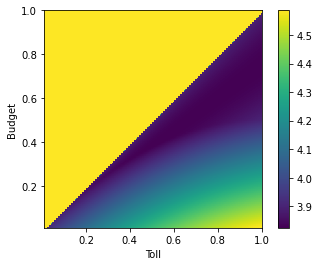

In [65]:
# lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0

# plt.imshow(welfare_obj_arr.T, vmin = min(welfare_obj_list), vmax = max(welfare_obj_list), origin='lower') 
plt.imshow(welfare_obj_arr.T, extent=[np.min(tau_arr), np.max(tau_arr), np.min(B_arr), np.max(B_arr)], \
           vmin = min(welfare_obj_list), vmax = max(welfare_obj_list), origin='lower') 

plt.colorbar() 
plt.xlabel("Toll")
plt.ylabel("Budget")
# plt.xticks(x_positions, x_labels)

In [ ]:
# Test:

grad = np.array([3.11430535, 1.501, 1.501, 2.46858321, 1.501])

# y_el: \hat y_1 E, \tilde y_1 E, y_2 E
y_el_var = cp.Variable(3)
# y_in: y_1 I, y_2 I
y_in_var = cp.Variable(2)

objective = cp.Minimize(grad[0:3] @ y_el_var + grad[3:] @ y_in_var)

constraints = []
constraints += [y_el_var >= 0, y_in_var >= 0]
constraints += [cp.sum(y_el_var) == 1, cp.sum(y_in_var) == 1]
constraints += [y_el_var[1] * tau <= B]

prob = cp.Problem(objective, constraints)
result = prob.solve()

print("grad:", grad)
print("y_el_var.value:", y_el_var.value)
# print("y_el_var_current:", y_el_var_current)
print("y_in_var.value:", y_in_var.value)
# print("y_in_var_current:", y_in_var_current)
print()

# y_el_var_current = y_el_var_current + 2/(k+2) * (y_el_var.value - y_el_var_current)
# y_in_var_current = y_in_var_current + 2/(k+2) * (y_in_var.value - y_in_var_current)

# y_iters[0:3, k] = y_el_var_current
# y_iters[3:, k] = y_in_var_current

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()

# Solver=SCS,verbose=False

In [ ]:
# y_el_var
# y_in_var
# np.hstack((y_el_var, y_in_var))

# Scratch Work:

In [ ]:
x = cp.Variable(2)
y = cp.Variable(2)
v_fixed = np.array([0, 1])
objective = cp.Minimize(cp.sum_squares(x - y) + cp.sum_squares(x - v_fixed))
constraints = []
# for i in range(2):
#     constraints += [x[i] >= 2]
# constraints += [x[i] >=2 for i in range(2)]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print("x.value:", x.value)
print("y.value:", y.value)
print()


# Old Code Below:

# Budget vs Discount - Theory

## 1 Eligible group, 1 Ineligible group (Theory)

In [ ]:
def F_11(val, ell, tau, alpha):
    return ell(val) + (1 - alpha) * tau - ell(2 - val)

def y_star_11(ell, tau, alpha, lb_init = 0.0, ub_init = 2.0, num_iters = 20):
    # Searches for y^\star satisfying ell(y^\star) + (1 - \alpha) \tau = ell(2 - y^\star)
    
    assert tau < ell(ub_init) - ell(lb_init), "We must have tau < ell(2.0) - ell(0.0), else is trivial."
    assert 0.0 <= alpha <= 1.0, "We must have 0.0 <= alpha <= 1.0"
    assert ell(lb_init) + (1.0 - alpha) * tau < ell(ub_init)
    
    lb = lb_init
    ub = ub_init
    mid_val = (lb + ub)/2
    
    for k in range(num_iters):
#         print("F:", F_11(mid_val, ell, tau, alpha))
#         print("lb:", lb)
#         print("ub:", ub)
#         print("mid_val:", mid_val)
#         print()
        
        if F_11(mid_val, ell, tau, alpha) < 0:
            lb = mid_val
        else:
            ub = mid_val
        mid_val = (lb + ub)/2
    
    return (lb + ub)/2

# def fixed_point_eqn():
    


In [ ]:
t_1 = time.time()

ell = lambda x: x**4 / 16
# ell = lambda x: np.log(1 + np.exp(x))
# alpha = 0.0

# # Case 1: 
# tau = 0.4
# v_E = 1
# v_I = 1.25

# # Case 2: 
# tau = 0.7
# v_E = 1
# v_I = 1.25

# Case 3: 
tau = 0.7
v_E = 1
v_I = 2.5

num_alpha_grid_points = 100 # Should be even
alpha_vals = np.linspace(0, 1.0, num = num_alpha_grid_points + 1)

y_star_zero = y_star_11(ell, tau, alpha = 0.0, lb_init = 0.0, ub_init = 2.0)
# print("y_star_zero:", y_star_zero)

y_star_vals = np.array([y_star_11(ell, tau, alpha, lb_init = 0.0, ub_init = 2.0) for alpha in alpha_vals])
y_star_vals_budget = alpha_vals
index_max = max([k for k in list(range(num_alpha_grid_points)) if alpha_vals[k] <= 1 - v_E/v_I])
# print("index_min:", index_min)
# print("alpha_vals[index_min]:", alpha_vals[index_min])
# print("y_star_vals_budget:", y_star_vals_budget)
# print()

# print("y_star_vals:", y_star_vals)
# print()

y_star_vals_discount = np.copy(y_star_vals)
for k in range(y_star_vals_discount.shape[0]):
    if k <= index_max:
        y_star_vals_discount[k] = 0.0

tau_thresh_for_alpha_3 = 2 * v_E * (ell(1) - ell(1 - 1E-6)) / 1E-6
index_for_alpha_3 = max([k for k in list(range(num_alpha_grid_points)) if y_star_vals[k] >= alpha_vals[k] ])
alpha_3 = (y_star_vals[index_for_alpha_3] + y_star_vals[index_for_alpha_3 + 1])/2

# print("y_star_vals_budget:", y_star_vals_budget)

# print("y_star_vals_budget:", y_star_vals_budget)


t_2 = time.time()
print("Time:", t_2 - t_1)

In [ ]:
print("1 - v^E / v^I:", 1 - v_E/v_I)
print("alpha_3:", alpha_3)

In [ ]:
plt.rcParams['text.usetex'] = True
# plt.rcParams['text.usetex'] = False

plt.plot(alpha_vals, y_star_vals_discount, 'red')
plt.plot(alpha_vals, y_star_vals_budget, 'blue')
# plt.scatter(alpha_vals, y_star_vals_discount, marker = 'o', s = 0.5, color = 'purple')
# plt.scatter(alpha_vals, y_star_vals_budget, marker = 'o', s = 0.5, color = 'black')
plt.xlim([0, 1.0])
plt.ylim([-0.2, 1.2])

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel(r'$\displaystyle \alpha$', fontsize=24)
plt.ylabel(r'$\displaystyle y^C, y^D$', fontsize=24)
# plt.ylabel(r'$\displaystyle \ln(L^t - L^\star)$', fontsize=16)

# Scratch Work:

In [47]:
# Test:

# y_el: \hat y_1 E, \tilde y_1 E, y_2 E
y_elig = cp.Variable(3)
# y_in: y_1 I, y_2 I
y_inel = cp.Variable(2)

a = np.array([0.0, 0.0, 0.0, 0.0, 1.0])

tau = 0.5
B = 0.4

func = 1/5 * a[4] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 5)
func += 1/4 * a[3] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 4)
func += 1/3 * a[2] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 3)
func += 1/2 * a[1] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 2)
func += a[0] * (y_elig[0] + y_elig[1] + y_inel[0])
func += y_inel[0] * tau / v_I + y_elig[0] * tau / v_E
func += 1/5 * a[4] * cp.power(y_elig[2] + y_inel[1], 5)
func += 1/4 * a[3] * cp.power(y_elig[2] + y_inel[1], 4)
func += 1/3 * a[2] * cp.power(y_elig[2] + y_inel[1], 3)
func += 1/2 * a[1] * cp.power(y_elig[2] + y_inel[1], 2)
func += a[0] * (y_elig[2] + y_inel[1])

objective = cp.Minimize(func)


constraints = []
constraints += [y_elig >= 0, y_inel >= 0]
constraints += [cp.sum(y_elig) == 1, cp.sum(y_inel) == 1]
constraints += [y_elig[1] * tau <= B]

prob = cp.Problem(objective, constraints)
result = prob.solve()

print("y_elig.value:", np.round(y_elig.value, 4) )
print("y_inel.value:", np.round(y_inel.value, 4) )
print()



# power(x, p)



y_elig.value: [0.  0.8 0.2]
y_inel.value: [0.1377 0.8623]

